# 统计图表生产过程  
1、十种颜色样点的标注  
2、十种颜色样点坐标的生成  
3、三个时相数据的区域统计  
4、土地利用类型数据区域统计  
5、前三步的表格合并  
6、上一步的表格汇总  
7、统计图表绘制

*也就是说，绘制这里统计图的前提是采样点都选好了*

# 采样点坐标信息转Excel
确定shp文件所在的路径就行，excel就生成在同文件夹下

先在ArcMap里通过Add XY Coordination工具，添加经纬度数据

In [ ]:
import os
import arcpy
import sys
import xlwt
import datetime

class clsField(object):
    @property
    def alias(self):
        return self._field.aliasName

    @property
    def name(self):
        return self._field.name

    @property
    def domain(self):
        return self._field.domain

    @property
    def type(self):
        return self._field.type

    @property
    def length(self):
        return self._field.length

    def __init__(self, f, i, subtypes, cvdomains):
        self._field = f
        self.subtype_field = ''
        self.domain_desc = {}
        self.subtype_desc = {}
        self.index = i

        if f.domain:
            for cvd in cvdomains:
                if cvd.name == f.domain:
                    self.domain_desc = {0 : cvd.codedValues}

        for st_key, st_val in subtypes.iteritems():
            if st_val['SubtypeField'] == f.name:
                self.subtype_desc[st_key] = st_val['Name']
                self.subtype_field = f.name
            for k, v in st_val['FieldValues'].iteritems():
                if k == f.name:
                    if len(v) == 2:
                        if v[1]:
                            self.domain_desc[st_key]= v[1].codedValues
                            self.subtype_field = st_val['SubtypeField']

    def __repr__(self):
        return '<clsfield object name={}, alias={}, domain_desc={}>'.format(
                                     self.name, self.alias, self.domain_desc)

    def updateValue(self, row, fields):
        value = row[self.index]
        if self.subtype_field:
            subtype_val = row[fields.index(self.subtype_field)]
        else:
            subtype_val = 0

        if self.subtype_desc:
            value = self.subtype_desc[row[self.index]]

        if self.domain_desc:
            try:
                value = self.domain_desc[subtype_val][row[self.index]]
            except:
                pass

        return value
def get_field_defs(in_table, use_domain_desc):
    desc = arcpy.Describe(in_table)

    subtypes  = {}
    cvdomains = {}
    if use_domain_desc:
        subtypes = arcpy.da.ListSubtypes(in_table)
        ws = os.path.dirname(arcpy.Describe(in_table).catalogPath)
        if arcpy.Describe(ws).dataType == 'FeatureDataset':
            ws = os.path.dirname(ws)
        cvdomains = [i for i in arcpy.da.ListDomains(ws)
                        if (i.domainType == 'CodedValue')]

    fields = []
    for i, field in enumerate([f for f in desc.fields
                               if f.type in ["Date", "Double", "Guid",
                                             "Integer", "OID", "Single",
                                             "SmallInteger", "String",
                                             "GlobalID"]]):
        fields.append(clsField(field, i, subtypes, cvdomains))

    return fields
def validate_sheet_name(sheet_name):
    import re
    if len(sheet_name) > 31:
        sheet_name = sheet_name[:31]

    r = re.compile(r'[:\\\/?*\[\]]')
    sheet_name = r.sub("_", sheet_name)

    return sheet_name
def add_error(id, s=None):

    arcpy.AddIDMessage("ERROR", id, s if s else None)
    if __name__ == '__main__':
        sys.exit(1)
    else:
        raise arcpy.ExecuteError(arcpy.GetIDMessage(id))
def table_to_excel(in_table, output, use_field_alias=False, use_domain_desc=False):

    fields = get_field_defs(in_table, use_domain_desc)

    if os.path.isfile(output):
        if arcpy.env.overwriteOutput == False:
            add_error(258, output)
        else:
            os.remove(output)

    if int(arcpy.GetCount_management(in_table)[0]) > 65535:
        add_error(1531)

    elif len(fields) > 255:
        add_error(1530)

    workbook = xlwt.Workbook()
    worksheet = workbook.add_sheet(
        validate_sheet_name(os.path.splitext(os.path.basename(output))[0]))

    header_style = xlwt.easyxf("font: bold on; align: horiz center; pattern: pattern solid, fore-colour 0x16;")

    for index, field in enumerate(fields):
        worksheet.write(0, index, field.alias if use_field_alias else field.name , header_style)
        if field.type == 'String':
            worksheet.col(index).width = min(50, field.length)*256
        else:
            worksheet.col(index).width = 16*256

    worksheet.set_panes_frozen(True)
    worksheet.set_horz_split_pos(1)
    worksheet.set_remove_splits(True)

    styleDefault = xlwt.XFStyle()

    styleDate = xlwt.XFStyle()
    styleDate.num_format_str = 'YYYY-MM-DD'

    styleTime = xlwt.XFStyle()
    styleTime.num_format_str = 'h:mm'

    styleDateTime = xlwt.XFStyle()
    styleDateTime.num_format_str = 'YYYY-MM-DD h:mm'

    styleInt = xlwt.XFStyle()
    styleInt.num_format_str = '0'

    field_names = [i.name for i in fields]
    with arcpy.da.SearchCursor(in_table, field_names) as cursor:
        row_index = 1
        for row in cursor:
            for col_index, value in enumerate(row):
                if (fields[col_index].domain_desc or fields[col_index].subtype_desc):
                    value = fields[col_index].updateValue(row, field_names)

                if isinstance(value, datetime.datetime):
                    if (value.hour == 0) and (value.minute == 0):
                        style = styleDate
                    elif (value.year == 1899) and (value.month == 12) and (value.day == 30):
                        style = styleTime
                        value = (value-datetime.datetime(1899, 12,30,0,0,0)).total_seconds()/86400.0
                    else:
                        style = styleDateTime

                elif isinstance(value, int):
                    style = styleInt

                else:
                    style = styleDefault

                worksheet.write(row_index, col_index, value, style)
            row_index+=1

    workbook.save(output)

table_path_root = r'F:\Data\Extension_Research\Multitemporal_Research_CN\RandomPoints\shp'
table_pathname = os.listdir(table_path_root)
table_list = []

for name in table_pathname:
    path = os.path.join(table_path_root, name)
    if path[-4:] == '.dbf':
        table_list.append(path)
for table in table_list:
    excel = table[:-4]+'.xls'
    print(excel)
    print(table)
    t2e = table_to_excel(table, excel, use_field_alias=False, use_domain_desc=False)
print('finish')

# 区域统计 Arcpy

## 三时相及土地利用的区域统计
需要确定**土地利用类型数据和RGB各波段灯光数据的所在文件夹**、**采样点shp所在文件夹**和**输出文件夹**  
这里的文件夹需要自行创建  
输出为table的形式，在文件夹里会产生.cpg、.dbf、.xml三种文件  
功能需要在ArcGIS中应用Arcpy运行

In [20]:
# 空文件夹的创建
import os
 
def mkdir(path):
    folder = os.path.exists(path)
    if not folder: 
        os.makedirs(path) 
        print('successful create new folder')
    else:
        print('already exist')
        
file_prefix = r"F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn"
file_suffix = ['White', 'WhitePink', 'WhiteBlue', 'WhiteYellow', 'PinkPurple', 'BlueGreen', 'YellowOrange',
              'Red', 'Green', 'Blue']
for suffix in file_suffix:
    file_path = os.path.join(file_prefix, suffix)
    mkdir(file_path)

successful create new folder
successful create new folder
successful create new folder
successful create new folder
successful create new folder
successful create new folder
successful create new folder
successful create new folder
successful create new folder
successful create new folder


In [18]:
# 文件夹及文件的删除
import os

path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test'
file_list = os.listdir(path)
for item in file_list:
    if item.find('.') == -1:
        folder_path = os.path.join(path, item)
        print('folder:   '+ folder_path)
        os.rmdir(folder_path) 
    else:
        file_path = os.path.join(path, item)
        print('file:   '+ file_path)
        # os.remove(file_path)
os.listdir(path)

folder:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\Blue
folder:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\BlueGreen
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\DVNL_2013.cpg
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\DVNL_2013.dbf
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\DVNL_2013.dbf.xml
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\F152013_intercal.cpg
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\F152013_intercal.dbf
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\F152013_intercal.dbf.xml
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\F152013_intercal.xls
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\F182013.cpg
file:   F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_test\F182013.dbf
file:   F:\Data\Extension_Resea

['DVNL_2013.cpg',
 'DVNL_2013.dbf',
 'DVNL_2013.dbf.xml',
 'F152013_intercal.cpg',
 'F152013_intercal.dbf',
 'F152013_intercal.dbf.xml',
 'F152013_intercal.xls',
 'F182013.cpg',
 'F182013.dbf',
 'F182013.dbf.xml',
 'F182013.xls',
 'MCD12C1_LC_2013.cpg',
 'MCD12C1_LC_2013.dbf',
 'MCD12C1_LC_2013.dbf.xml',
 'MCD12C1_LC_2013.xls']

**Arcpy!Arcpy!Arcpy!**

In [ ]:
import os
import arcpy
from arcpy import env
from arcpy.sa import *

workspace_list = [r"F:\Data\Extension_Research\RGB_Composite\Landcover\MCD12Q1\cn_reclass",
                 r"F:\Data\Extension_Research\RGB_Composite\Composition\cn"]
output_path = r"F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn"
shp_path = r"F:\Data\Extension_Research\RGB_Composite\SamplePoints\sample_cn"

output_name_pre = os.listdir(output_path)
shp_name_pre = os.listdir(shp_path)
output_name, shp_name = [], []
for name in output_name_pre:
    if name.find('.') == -1:
        output_name.append(name)
for name in shp_name_pre:
    if name[-4:] == '.shp':
        shp_name.append(name)

zoneField = "FID"
for workspace in workspace_list:
    datanames = os.listdir(workspace)
    for i in range(len(output_name)):
        output = os.path.join(output_path, output_name[i])
        shp = os.path.join(shp_path, shp_name[i])
        
        count = 0
        for dataname in datanames:
            if os.path.splitext(dataname)[1] == '.tif':
                count = count + 1
                print(dataname)
        print('count:' + str(count))
        
        num = 1
        for dataname in datanames:
            if os.path.splitext(dataname)[1] == '.tif':
                data_name = os.path.splitext(dataname)[0]
                arcpy.CheckOutExtension("Spatial")

                file_name = data_name.split('.')[0]
                raster = workspace + "/" + dataname
                outTable = (output + "/" + file_name + ".dbf")
                print(outTable)
                outZSaT = ZonalStatisticsAsTable(shp, zoneField, raster, outTable, "DATA", "ALL")

                print(1.0 * num / count)
                num = num + 1
print('finish')

## 区域统计的Excel生成
只需确定table文件所在的文件夹即可，生成的excel直接就放在同文件夹下  
将产生.xls文件，及早版本的Excel文件  
功能需要在ArcGIS中应用Arcpy运行

**Arcpy!Arcpy!Arcpy!**

In [ ]:
import os
import arcpy
import sys
import xlwt
import datetime

class clsField(object):
    @property
    def alias(self):
        return self._field.aliasName

    @property
    def name(self):
        return self._field.name

    @property
    def domain(self):
        return self._field.domain

    @property
    def type(self):
        return self._field.type

    @property
    def length(self):
        return self._field.length

    def __init__(self, f, i, subtypes, cvdomains):
        self._field = f
        self.subtype_field = ''
        self.domain_desc = {}
        self.subtype_desc = {}
        self.index = i

        if f.domain:
            for cvd in cvdomains:
                if cvd.name == f.domain:
                    self.domain_desc = {0 : cvd.codedValues}

        for st_key, st_val in subtypes.iteritems():
            if st_val['SubtypeField'] == f.name:
                self.subtype_desc[st_key] = st_val['Name']
                self.subtype_field = f.name
            for k, v in st_val['FieldValues'].iteritems():
                if k == f.name:
                    if len(v) == 2:
                        if v[1]:
                            self.domain_desc[st_key]= v[1].codedValues
                            self.subtype_field = st_val['SubtypeField']

    def __repr__(self):
        return '<clsfield object name={}, alias={}, domain_desc={}>'.format(
                                     self.name, self.alias, self.domain_desc)

    def updateValue(self, row, fields):
        value = row[self.index]
        if self.subtype_field:
            subtype_val = row[fields.index(self.subtype_field)]
        else:
            subtype_val = 0

        if self.subtype_desc:
            value = self.subtype_desc[row[self.index]]

        if self.domain_desc:
            try:
                value = self.domain_desc[subtype_val][row[self.index]]
            except:
                pass

        return value
def get_field_defs(in_table, use_domain_desc):
    desc = arcpy.Describe(in_table)

    subtypes  = {}
    cvdomains = {}
    if use_domain_desc:
        subtypes = arcpy.da.ListSubtypes(in_table)
        ws = os.path.dirname(arcpy.Describe(in_table).catalogPath)
        if arcpy.Describe(ws).dataType == 'FeatureDataset':
            ws = os.path.dirname(ws)
        cvdomains = [i for i in arcpy.da.ListDomains(ws)
                        if (i.domainType == 'CodedValue')]

    fields = []
    for i, field in enumerate([f for f in desc.fields
                               if f.type in ["Date", "Double", "Guid",
                                             "Integer", "OID", "Single",
                                             "SmallInteger", "String",
                                             "GlobalID"]]):
        fields.append(clsField(field, i, subtypes, cvdomains))

    return fields
def validate_sheet_name(sheet_name):
    import re
    if len(sheet_name) > 31:
        sheet_name = sheet_name[:31]

    r = re.compile(r'[:\\\/?*\[\]]')
    sheet_name = r.sub("_", sheet_name)

    return sheet_name
def add_error(id, s=None):

    arcpy.AddIDMessage("ERROR", id, s if s else None)
    if __name__ == '__main__':
        sys.exit(1)
    else:
        raise arcpy.ExecuteError(arcpy.GetIDMessage(id))
def table_to_excel(in_table, output, use_field_alias=False, use_domain_desc=False):

    fields = get_field_defs(in_table, use_domain_desc)

    if os.path.isfile(output):
        if arcpy.env.overwriteOutput == False:
            add_error(258, output)
        else:
            os.remove(output)

    if int(arcpy.GetCount_management(in_table)[0]) > 65535:
        add_error(1531)

    elif len(fields) > 255:
        add_error(1530)

    workbook = xlwt.Workbook()
    worksheet = workbook.add_sheet(
        validate_sheet_name(os.path.splitext(os.path.basename(output))[0]))

    header_style = xlwt.easyxf("font: bold on; align: horiz center; pattern: pattern solid, fore-colour 0x16;")

    for index, field in enumerate(fields):
        worksheet.write(0, index, field.alias if use_field_alias else field.name , header_style)
        if field.type == 'String':
            worksheet.col(index).width = min(50, field.length)*256
        else:
            worksheet.col(index).width = 16*256

    worksheet.set_panes_frozen(True)
    worksheet.set_horz_split_pos(1)
    worksheet.set_remove_splits(True)

    styleDefault = xlwt.XFStyle()

    styleDate = xlwt.XFStyle()
    styleDate.num_format_str = 'YYYY-MM-DD'

    styleTime = xlwt.XFStyle()
    styleTime.num_format_str = 'h:mm'

    styleDateTime = xlwt.XFStyle()
    styleDateTime.num_format_str = 'YYYY-MM-DD h:mm'

    styleInt = xlwt.XFStyle()
    styleInt.num_format_str = '0'

    field_names = [i.name for i in fields]
    with arcpy.da.SearchCursor(in_table, field_names) as cursor:
        row_index = 1
        for row in cursor:
            for col_index, value in enumerate(row):
                if (fields[col_index].domain_desc or fields[col_index].subtype_desc):
                    value = fields[col_index].updateValue(row, field_names)

                if isinstance(value, datetime.datetime):
                    if (value.hour == 0) and (value.minute == 0):
                        style = styleDate
                    elif (value.year == 1899) and (value.month == 12) and (value.day == 30):
                        style = styleTime
                        value = (value-datetime.datetime(1899, 12,30,0,0,0)).total_seconds()/86400.0
                    else:
                        style = styleDateTime

                elif isinstance(value, int):
                    style = styleInt

                else:
                    style = styleDefault

                worksheet.write(row_index, col_index, value, style)
            row_index+=1

    workbook.save(output)

table_path_root = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn'
table_pathname_list = os.listdir(table_path_root)
table_pathname = []
for pathname in table_pathname_list:
    if pathname.find('.') == -1:
        table_pathname.append(pathname)
for name in table_pathname:
    path = os.path.join(table_path_root, name)
    print(path)
    file_list = os.listdir(path)
    table_list = []
    for i in file_list:
        if i[-4:] == '.dbf':
            table_list.append(i)
    for table in table_list:
        table_root = os.path.join(path, table)
        excel = path+'\\'+table[:-4]+'.xls'
        t2e = table_to_excel(table_root, excel, use_field_alias=False, use_domain_desc=False)
print('finish')

# 表格合并
要确定RGB值excel所在的文件夹的上级文件夹和点坐标的文件夹

In [25]:
import os 
import pandas as pd

excel_path_prefix = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn'
sample_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\sample_cn'

excel_pathname_pre = os.listdir(excel_path_prefix)
sample_name_pre = os.listdir(sample_path)
excel_pathname, sample_name =[], []

for name in excel_pathname_pre:
    if name.find('.') == -1:
        excel_pathname.append(name)
for name in sample_name_pre:
    if name[-4:] == '.xls':
        sample_name.append(name)
for i in range(len(excel_pathname)):
    excel_path = os.path.join(excel_path_prefix, excel_pathname[i])
    sample_xls = os.path.join(sample_path, sample_name[i])
    name_list = os.listdir(excel_path)
    df = pd.DataFrame({'OID':list(range(0,1000))})
    for name in name_list:
        if name[-4:] == '.xls':
            col_name = name[:-4]
            path = os.path.join(excel_path, name)
            data = pd.read_excel(path, usecols=[0, 4])
            data.columns = ['OID', col_name]
            df = pd.merge(df, data, on='OID')
    xy_df = pd.read_excel(sample_xls, usecols=[0, 2, 3])
    df = pd.merge(df, xy_df.rename(columns={'FID':'OID'}), on='OID')
    df.columns = ['ID', 'Maize_raw', 'Rice_raw', 'Wheat_raw', 'crop_type', 'G', 'B', 'R', 'Landcover',
                  'Maize', 'Rice', 'Wheat', 'Longitude', 'Latitude']
    df = df[['ID', 'Longitude', 'Latitude', 'Landcover', 'crop_type', 'R', 'G', 'B']]

    def color(value):
        digit = list(map(str, range(10))) + list("ABCDEF")
        if isinstance(value, tuple):
            string = '#'
            for i in value: 
                a1 = i // 16
                a2 = i % 16
                string += digit[a1] + digit[a2]
            return string
        elif isinstance(value, str):
            a1 = digit.index(value[1]) * 16 + digit.index(value[2])
            a2 = digit.index(value[3]) * 16 + digit.index(value[4])
            a3 = digit.index(value[5]) * 16 + digit.index(value[6])
            return (a1, a2, a3)

    RGBvalue_list = []
    RGBtype_list = []
    for index, row in df.iterrows():
        R_value = row[4]*255/63
        G_value = row[5]*255/63
        B_value = row[6]*255/63
        RGB_value = color((int(R_value), int(G_value), int(B_value)))
        RGBvalue_list.append(RGB_value)
        if max(R_value,G_value,B_value) == R_value:
            RGB_type = 'R'
            RGBtype_list.append(RGB_type)
        elif max(R_value,G_value,B_value) == G_value:
            RGB_type = 'G'
            RGBtype_list.append(RGB_type)
        elif max(R_value,G_value,B_value) == B_value:
            RGB_type = 'B'
            RGBtype_list.append(RGB_type)
    df['RGB_value'] = RGBvalue_list
    df['RGB_type'] = RGBtype_list

    output_excel_name = 'info_colorPOI_'+excel_pathname[i]+'.xlsx'
    output_path = os.path.join(excel_path_prefix, output_excel_name)
#     print(output_path)
    df.to_excel(output_path)

# 表格汇总
需要确定分散的整合Excel路径以及要保存的汇总表格路径

In [26]:
import os
import pandas as pd

excel_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn'
excel_name = os.listdir(excel_path)
    
with pd.ExcelWriter(r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn.xlsx') as writer:
    for name in excel_name:
        if name[-5:] == '.xlsx':
            excel = os.path.join(excel_path, name)
            data = pd.read_excel(excel)
            data.to_excel(writer, sheet_name=name[14:-5])

# 统计图表生成
需要确定要读取的Excel和统计图表要存放的路径

dict_keys(['Blue', 'BlueGreen', 'Green', 'PinkPurple', 'Red', 'White', 'WhiteBlue', 'WhitePink', 'WhiteYellow', 'YellowOrange'])
{2: 21, 3: 34, 4: 6, 5: 11, 6: 5, 7: 1}


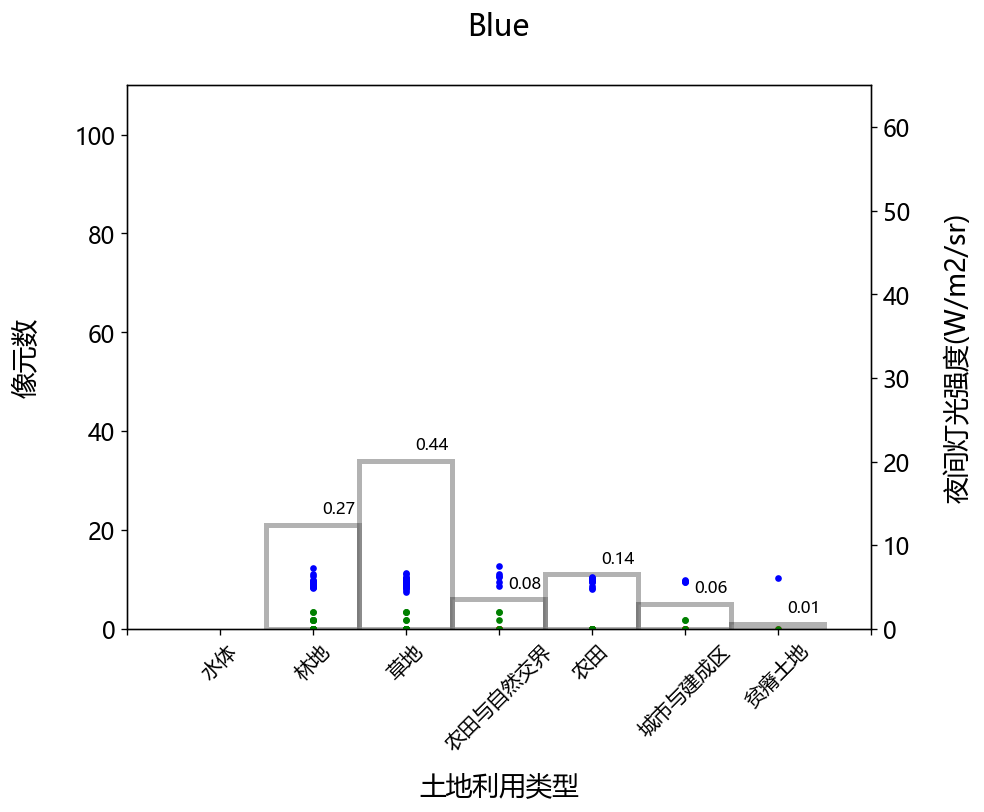

{1: 7, 2: 35, 3: 47, 4: 7, 5: 17, 6: 5, 7: 21}


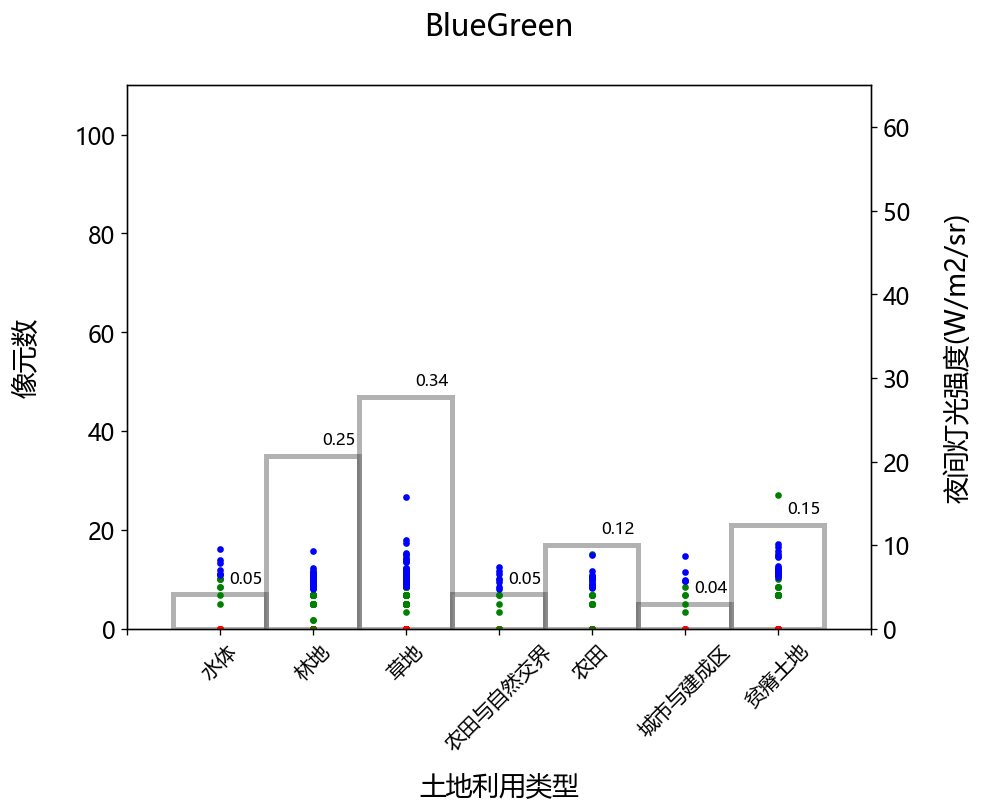

{2: 44, 3: 32, 4: 3, 5: 16, 6: 2, 7: 20}


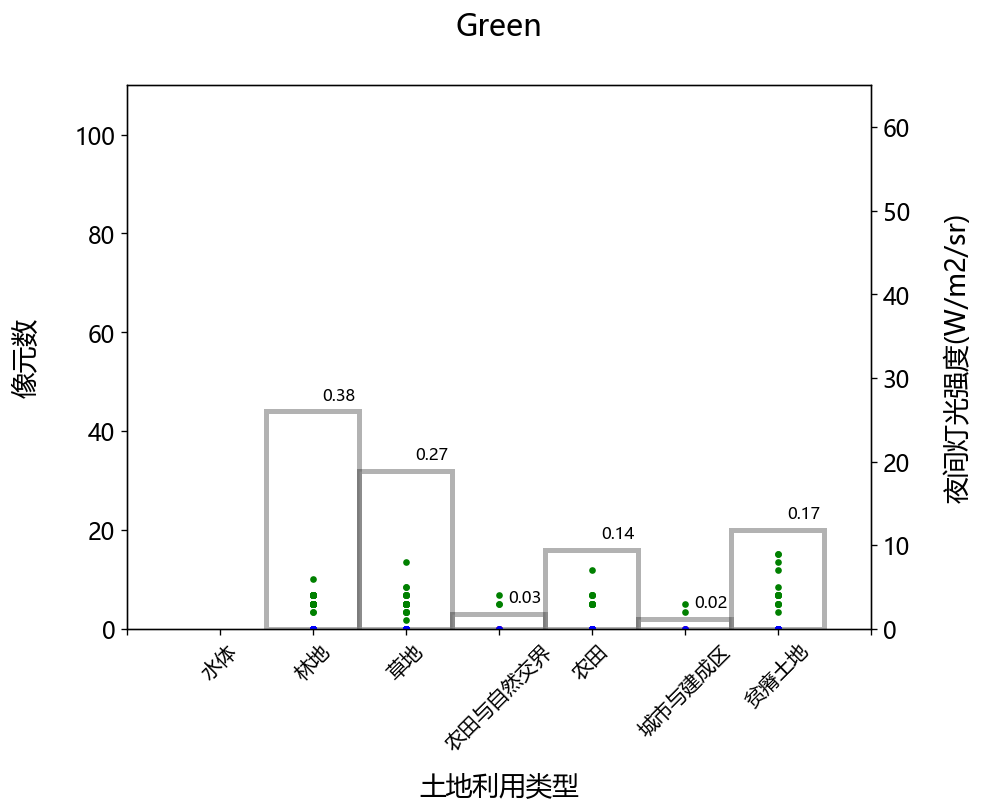

{1: 2, 2: 5, 3: 60, 4: 18, 5: 63, 6: 15, 7: 3}


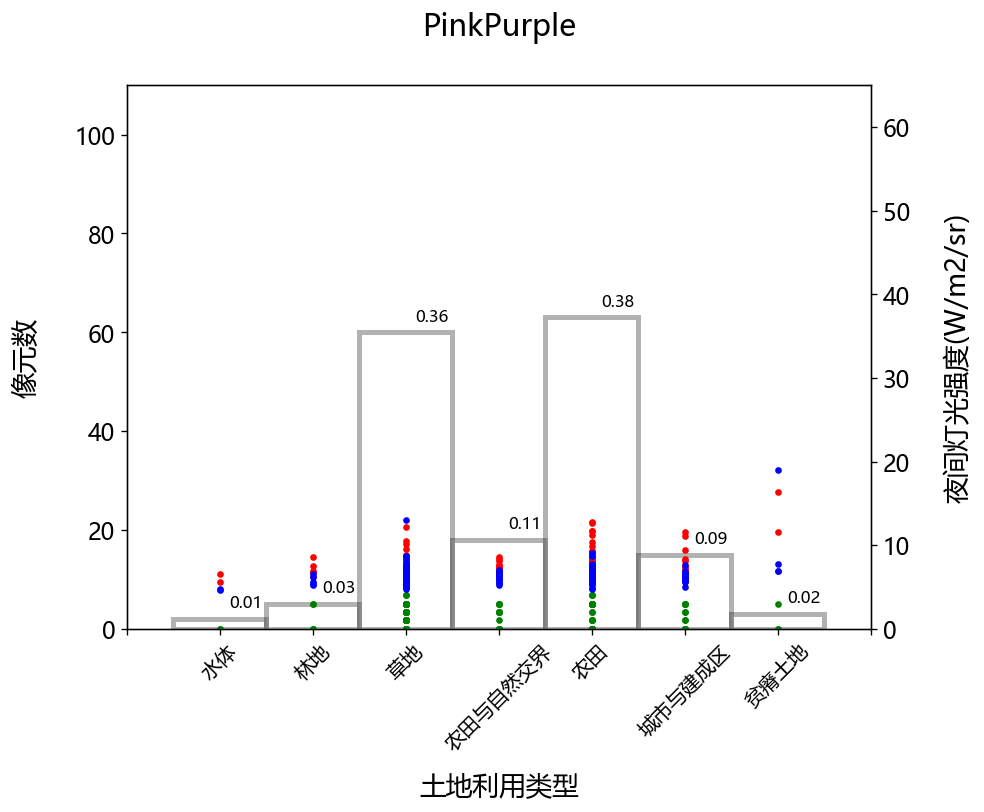

{2: 4, 3: 46, 4: 8, 5: 73, 6: 4, 7: 2}


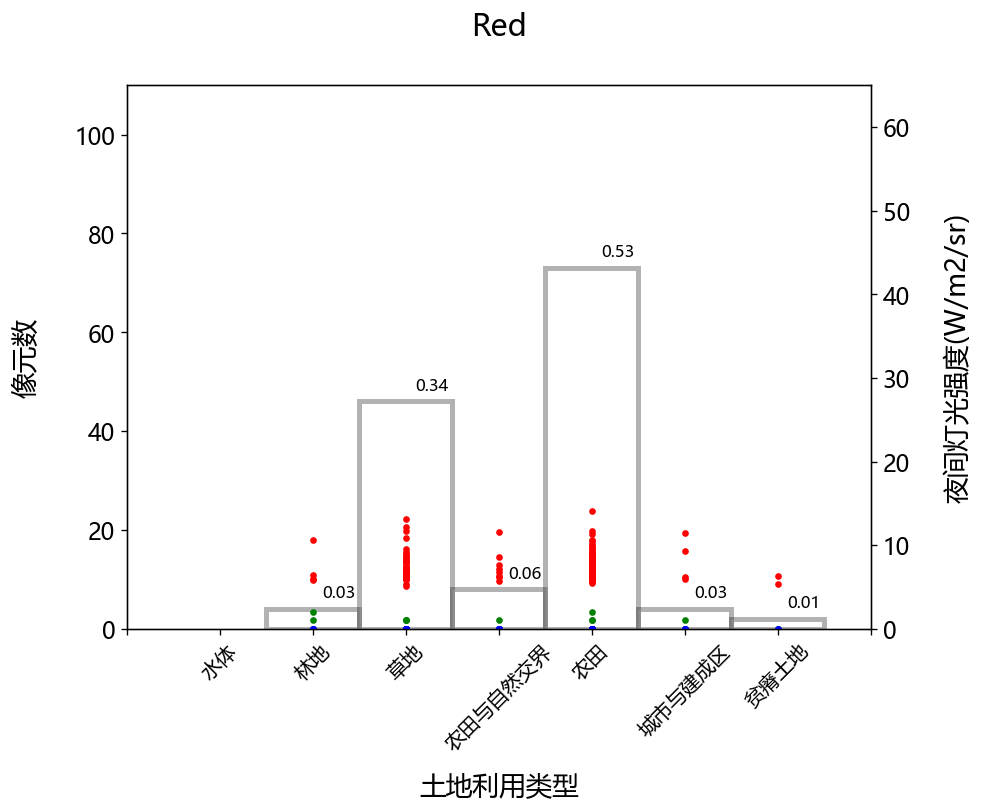

{1: 3, 2: 11, 3: 65, 4: 9, 5: 30, 6: 103, 7: 2}


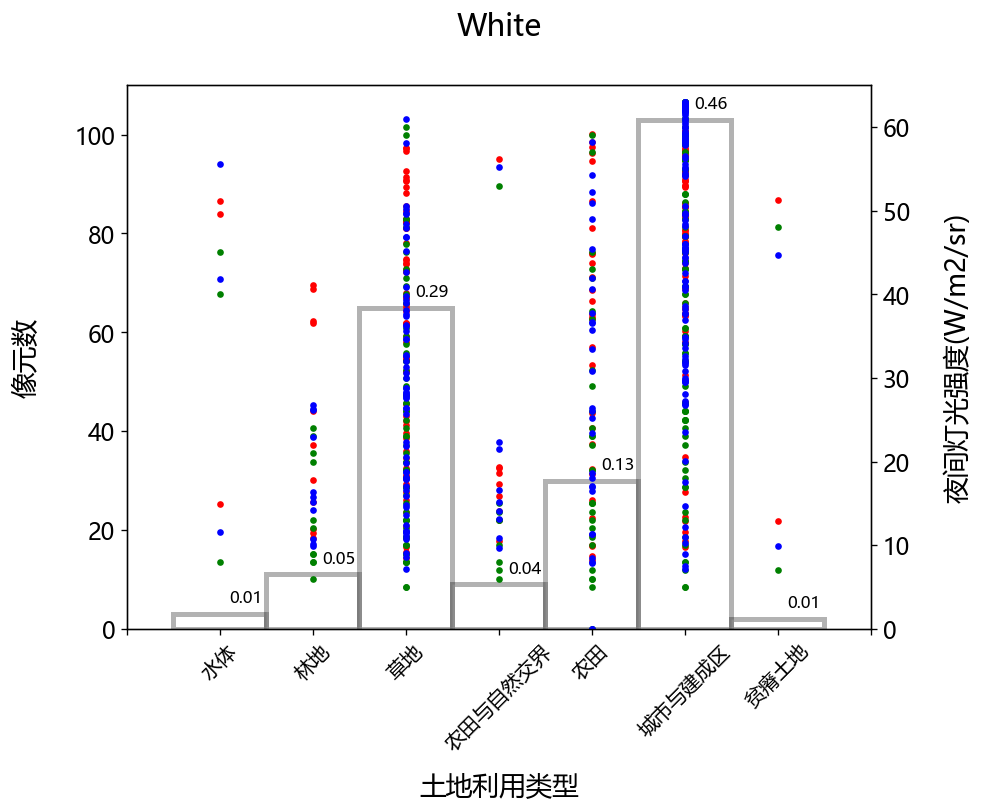

{1: 1, 2: 14, 3: 26, 4: 3, 5: 13, 6: 8, 7: 6}


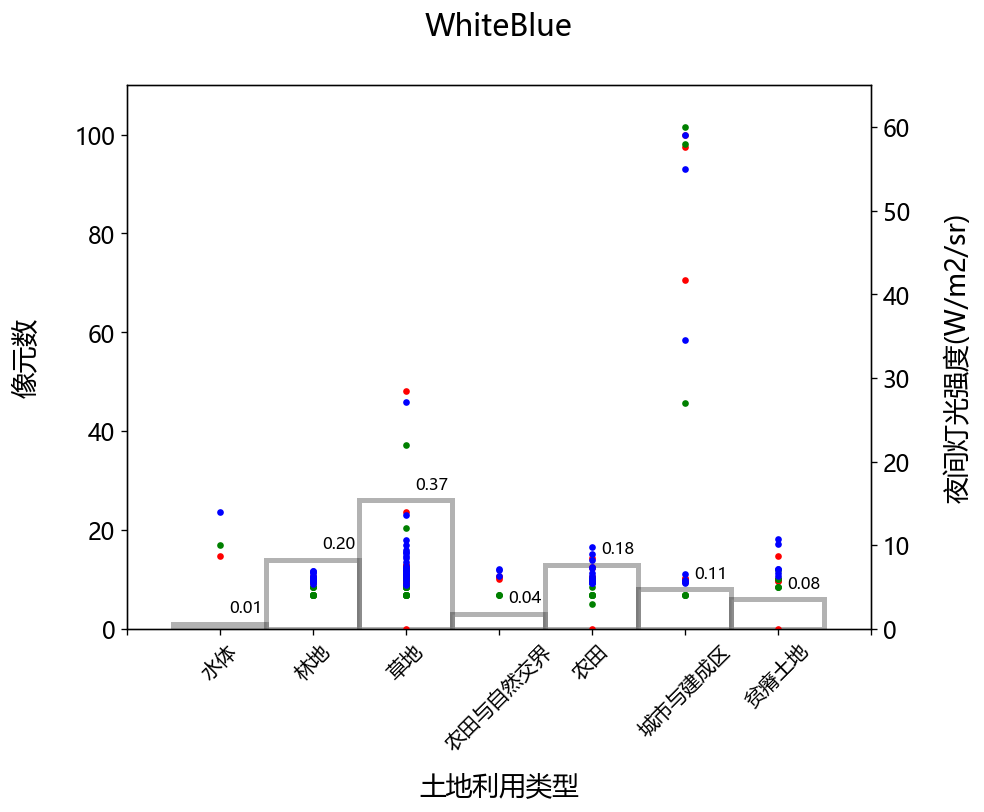

{1: 1, 2: 7, 3: 44, 4: 7, 5: 82, 6: 10, 7: 5}


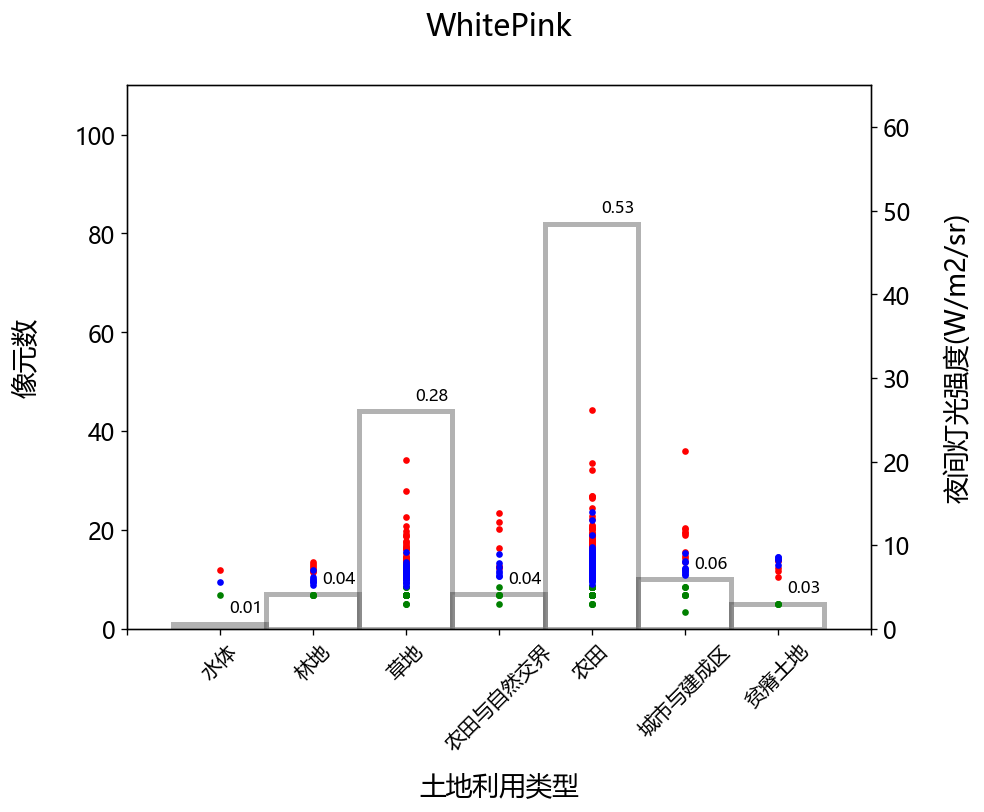

{2: 1, 3: 10, 5: 36, 6: 1}


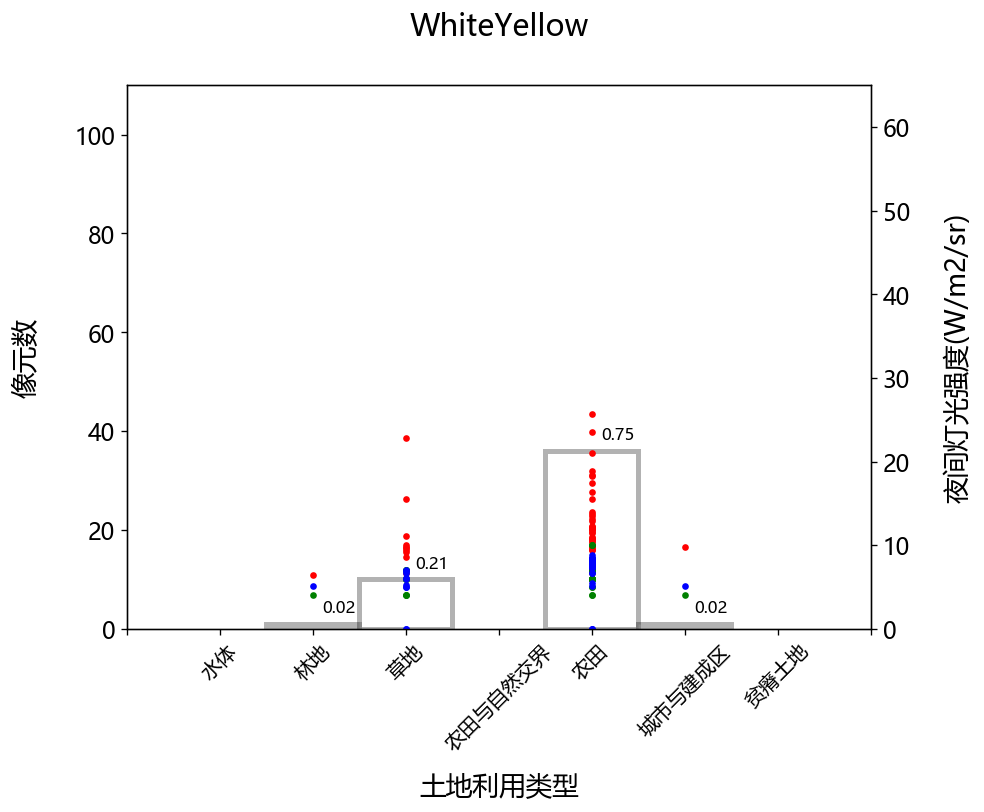

{1: 5, 2: 57, 3: 98, 4: 31, 5: 64, 6: 22, 7: 17}


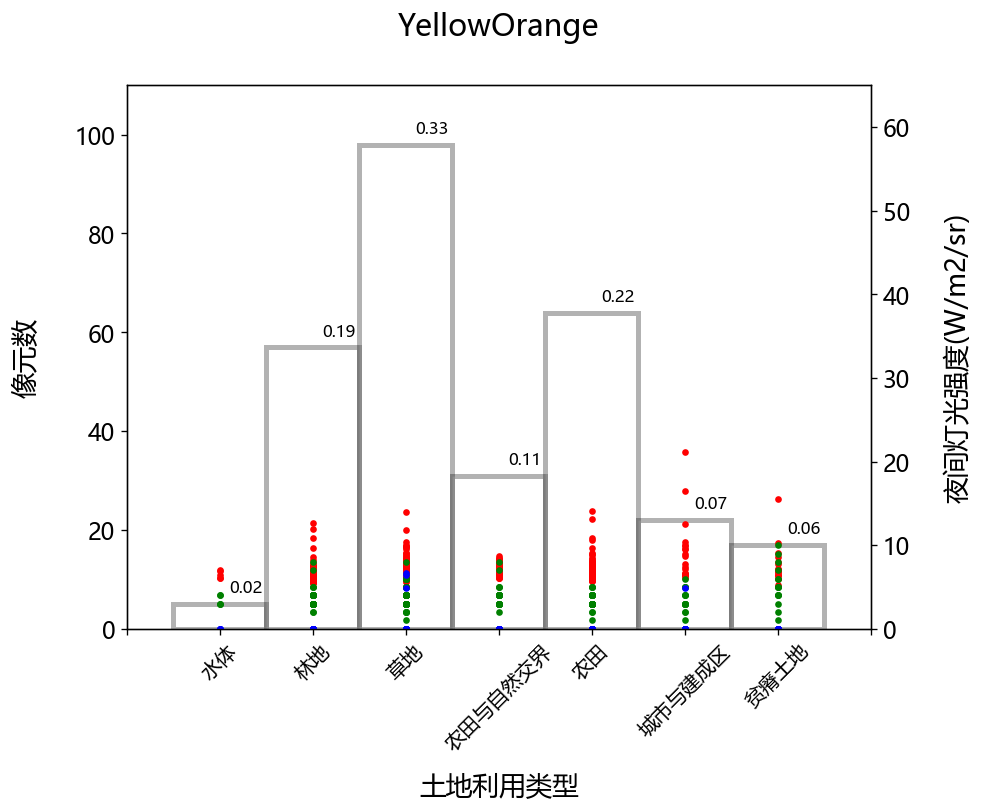

In [26]:
import openpyxl
import os
import xlsxwriter as xw
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# encoding:utf-8
ms_excel_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn.xlsx'
ms_excel = pd.read_excel(ms_excel_path, sheet_name=None)
print(ms_excel.keys())

fig_path_list = []
fig_name_list = []
num = 0
# 这里确定图表存放路径
for key in ms_excel:
    fig_prefix = 'graph_'
    fig_name = fig_prefix + key + '.jpg'
    fig_name_list.append(fig_name[6:-4])
    # 统计图表存放地址
    fig_root = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\graph_cn'
    fig_path = os.path.join(fig_root, fig_name)
    fig_path_list.append(fig_path)

for value in ms_excel.values():
    data = value[['Landcover', 'R', 'G','B']]
    Landcover_array = data[['Landcover']].values
    R_array = data[['R']].values
    G_array = data[['G']].values
    B_array = data[['B']].values

    unique, count=np.unique(Landcover_array, return_counts=True)
    data_count=dict(zip(unique,count))
    print(data_count)
    
    fig, ax1 = plt.subplots(figsize=(8,6), dpi=120)
    plt.xticks(range(17))
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False

    
    ax1.set_xlabel('土地利用类型', fontsize=16, labelpad=10)
    ax1.set_ylabel('像元数', fontsize=16, labelpad=20)
    ax1.bar(unique, count, width=1, color='w', alpha=0.3, edgecolor='black', linestyle = 'solid', linewidth=3)
    for a,b in zip(unique, count):
        sample_num = Landcover_array.shape[0]
        ax1.text(a+0.1, b+1.5, '%.2f'%(b/sample_num), ha='left', va='bottom')
    ax1.tick_params(axis='x', labelsize=14)
    ax1.tick_params(axis='y', labelsize=14)
    ax1.set_ylim(0,110)
    ax1.set_xticklabels([' ', '水体','林地','草地', '农田与自然交界','农田', '城市与建成区',
                         '贫瘠土地'],rotation=45, fontsize=12)
    
    ax2 = ax1.twinx()
    
    ax2.set_ylabel('夜间灯光强度(W/m2/sr)', fontsize=16, labelpad=20)
    ax2.scatter(Landcover_array, R_array, c='red', marker='.')
    ax2.scatter(Landcover_array, G_array, c='green', marker='.')
    ax2.scatter(Landcover_array, B_array, c='blue', marker='.')

    ax2.tick_params(axis='y', labelsize=14)
    ax2.set_ylim(0,65)
    
    plt.tick_params()
    plt.xlim(0,8)
    graph_title = fig_name_list[num]
    plt.title(graph_title, fontsize=18, pad=30)
    plt.show()
    
    file_path = fig_path_list[num]
    fig.savefig(file_path, bbox_inches='tight')
    num=num+1

# 数据特点折线图

dict_keys(['Blue', 'BlueGreen', 'Green', 'PinkPurple', 'Red', 'White', 'WhiteBlue', 'WhitePink', 'WhiteYellow', 'YellowOrange'])


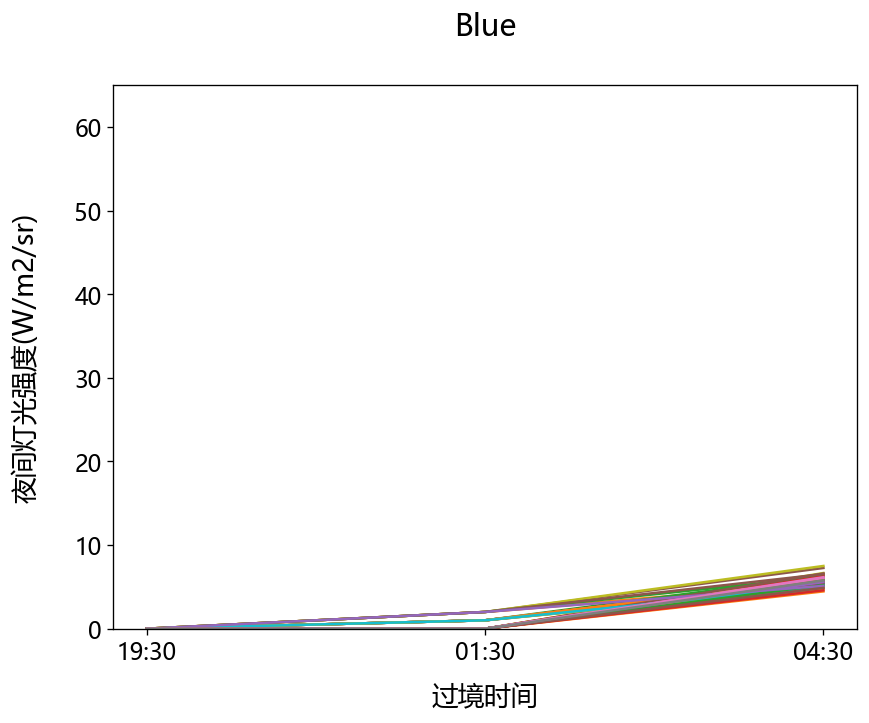

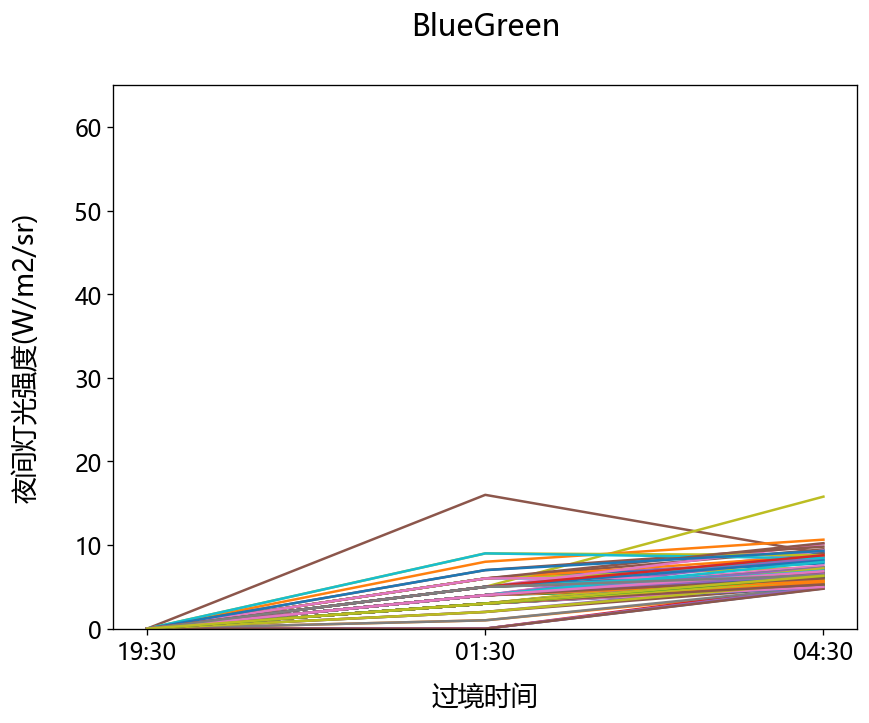

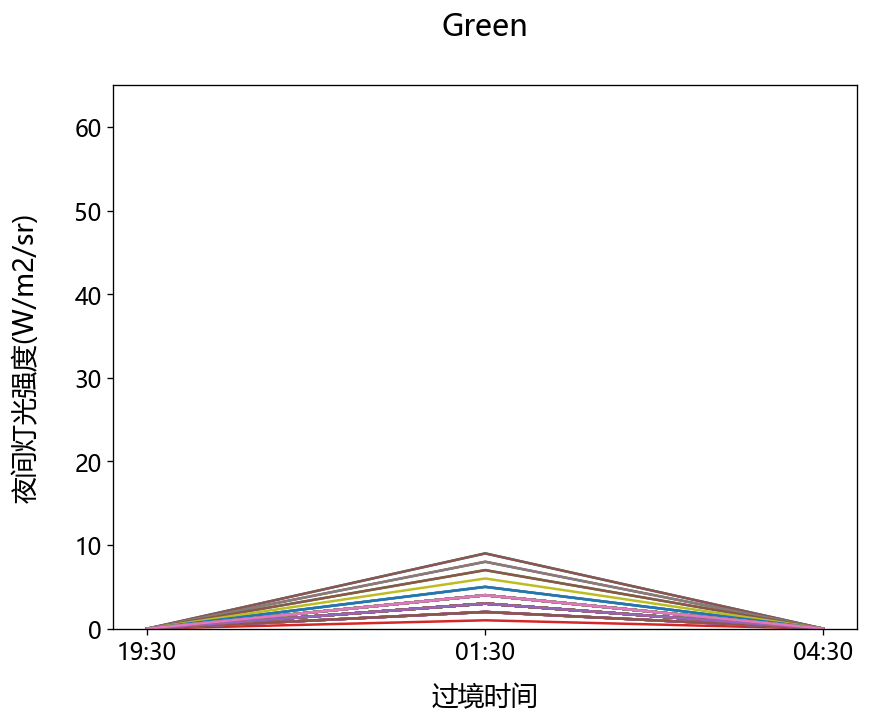

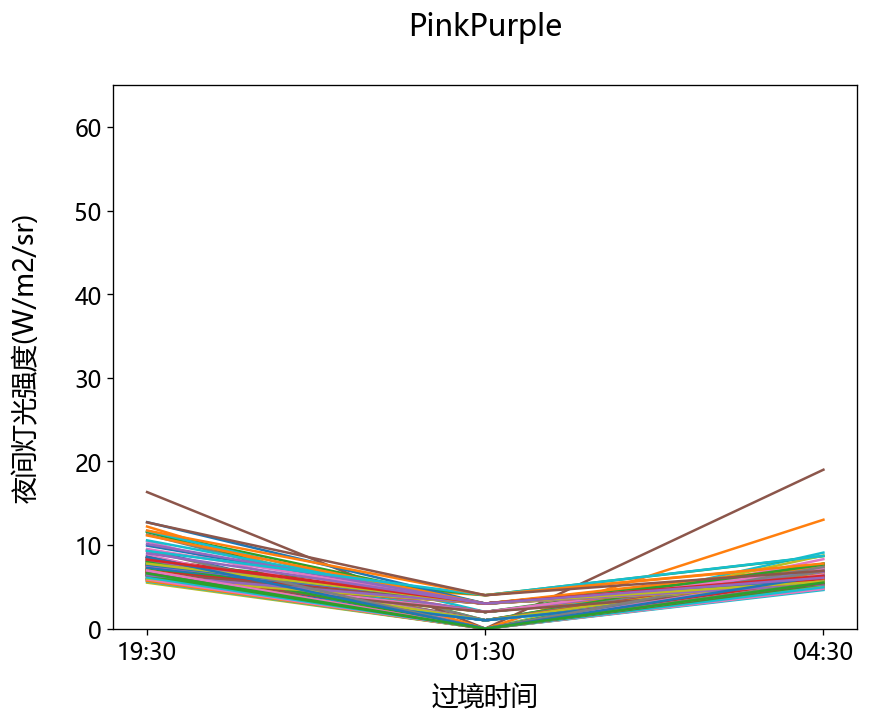

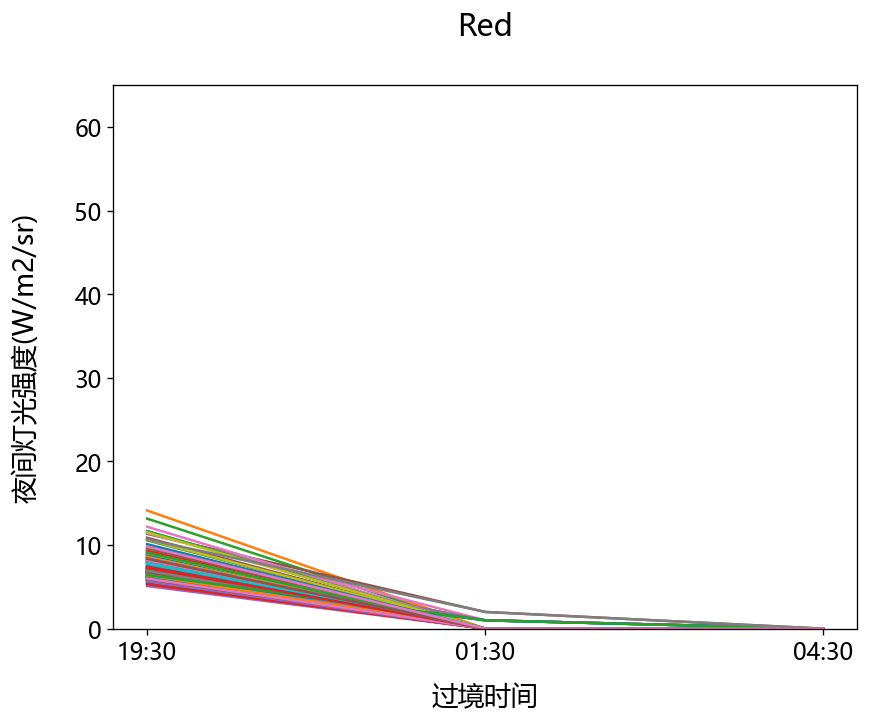

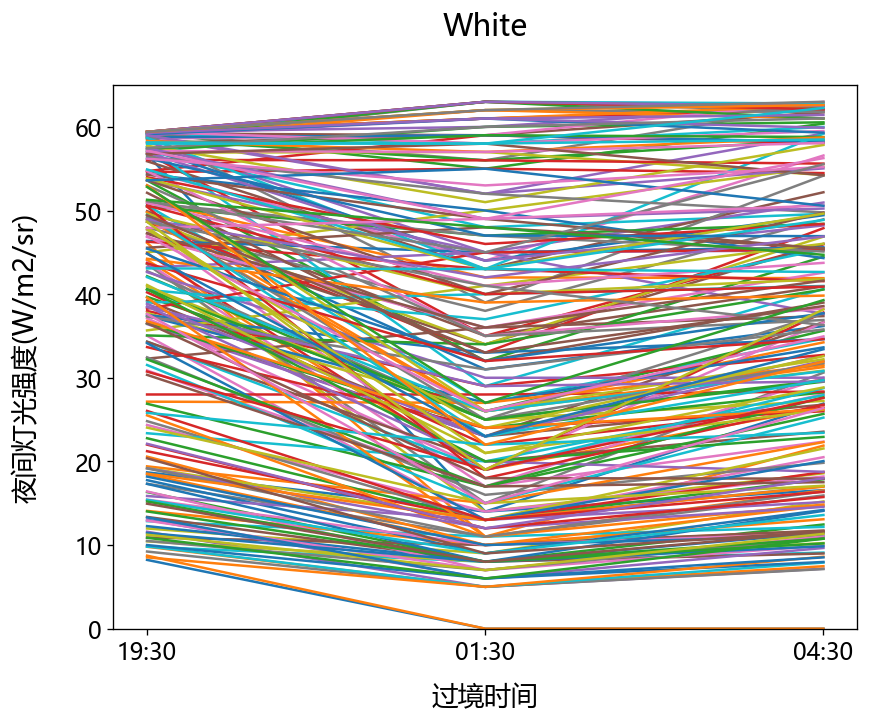

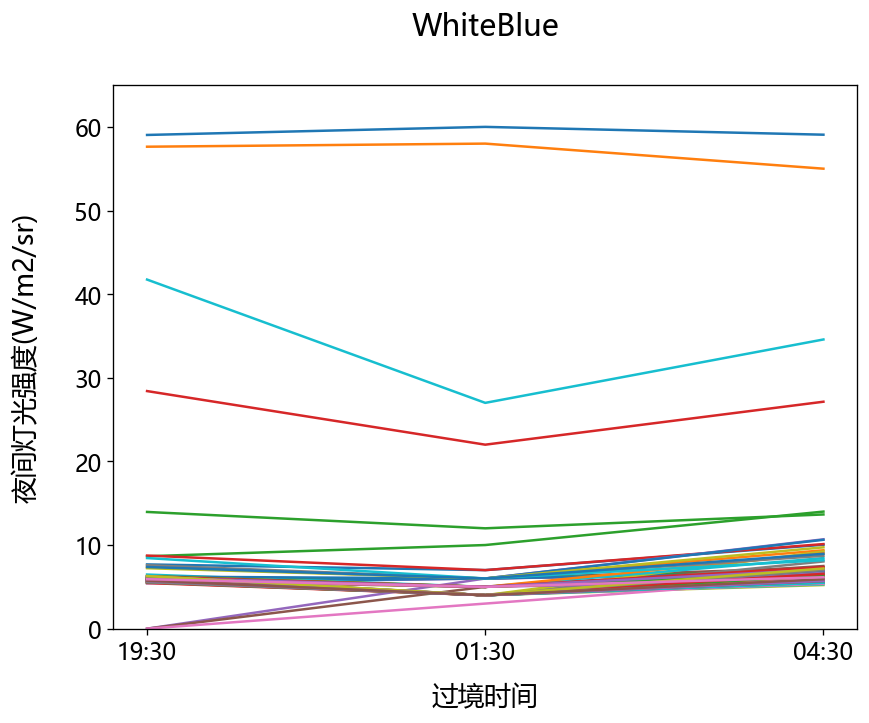

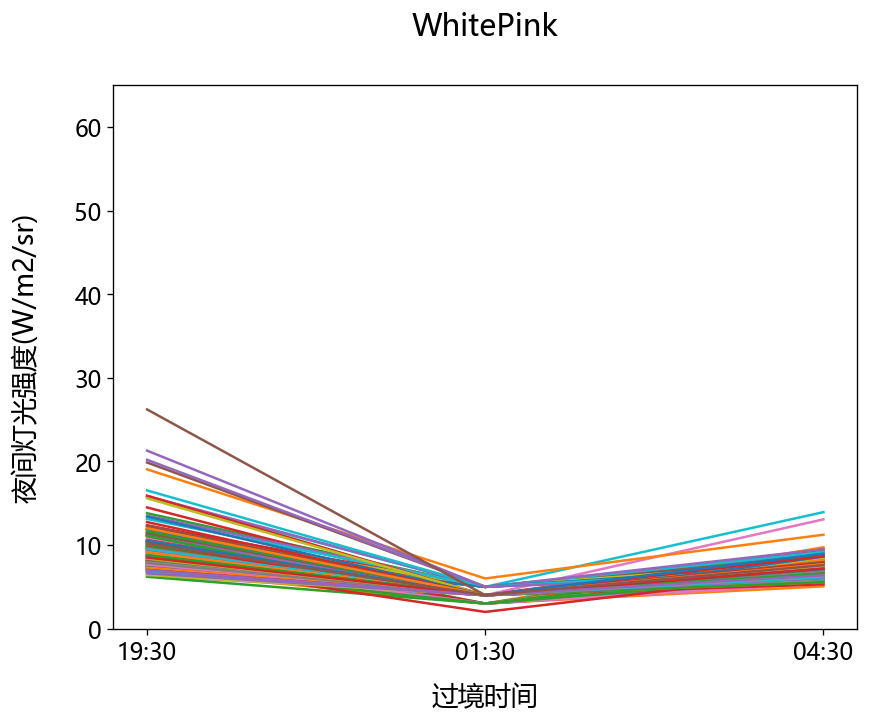

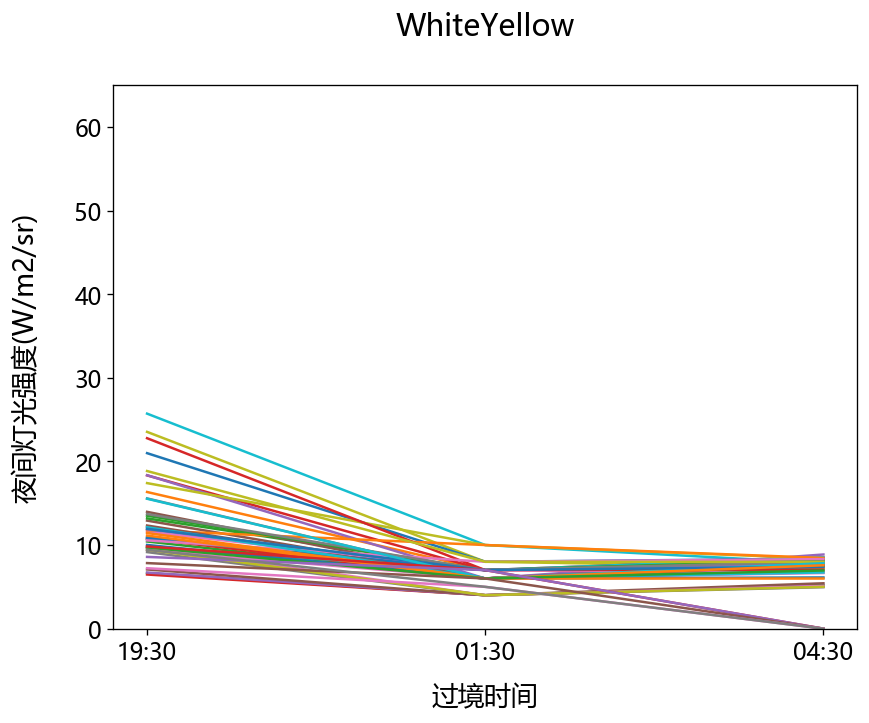

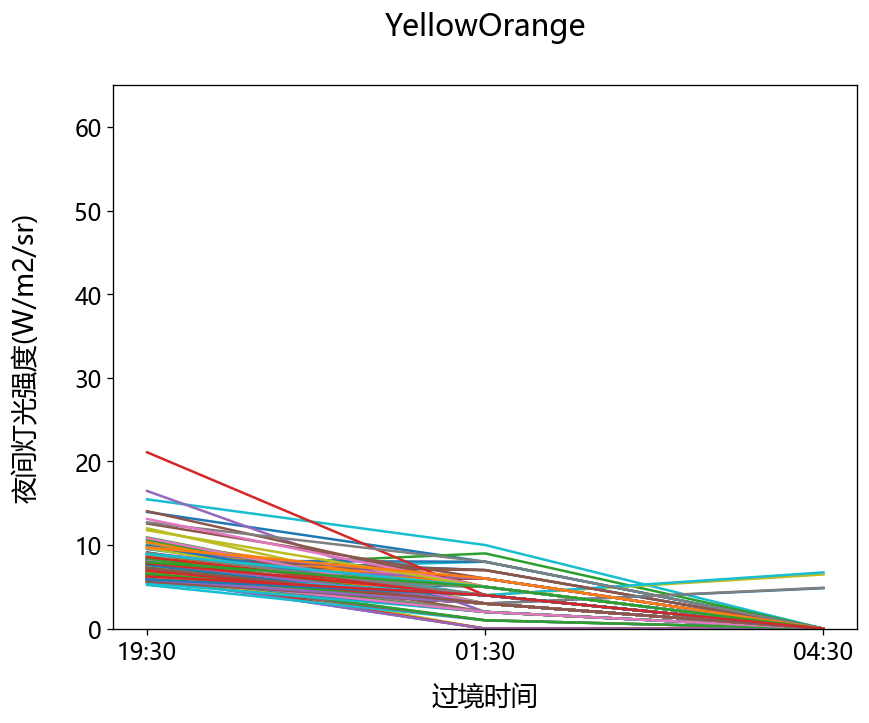

In [16]:
import openpyxl
import os
import xlsxwriter as xw
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

# encoding:utf-8
ms_excel_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn.xlsx'
ms_excel = pd.read_excel(ms_excel_path, sheet_name=None)
print(ms_excel.keys())

fig_path_list = []
fig_name_list = []
num = 0
# 这里确定图表存放路径
for key in ms_excel:
    fig_prefix = 'zhexian_'
    fig_name = fig_prefix + key + '.jpg'
    fig_name_list.append(fig_name[8:-4])
    # 统计图表存放地址
    fig_root = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\graph_cn'
    fig_path = os.path.join(fig_root, fig_name)
    fig_path_list.append(fig_path)
    
for value in ms_excel.values():
    data = value[['Landcover', 'R', 'G','B']]
    Landcover_array = data[['Landcover']].values
    R_array = data[['R']].values
    G_array = data[['G']].values
    B_array = data[['B']].values
    
    RGB_array = data[['R','G','B']].values

    fig, ax1 = plt.subplots(figsize=(8,6), dpi=120)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.ylim(0,65)
    plt.xlim(0.9,3.1)
    x_major_locator=MultipleLocator(1)
    
    for i in RGB_array:
        ax1.plot([1,2,3], i)
        ax1.set_xlabel('过境时间', fontsize=16, labelpad=10)
        ax1.set_ylabel('夜间灯光强度(W/m2/sr)', fontsize=16, labelpad=20)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.xaxis.set_major_locator(x_major_locator)
        ax1.set_xticklabels([' ','19:30','01:30','04:30'])

    graph_title = fig_name_list[num]
    plt.title(graph_title, fontsize=18, pad=30)
    plt.show()
    
    file_path = fig_path_list[num]
    fig.savefig(file_path, bbox_inches='tight')
    num=num+1

# 数据特点箱型图

## 所有土地利用类型的数据

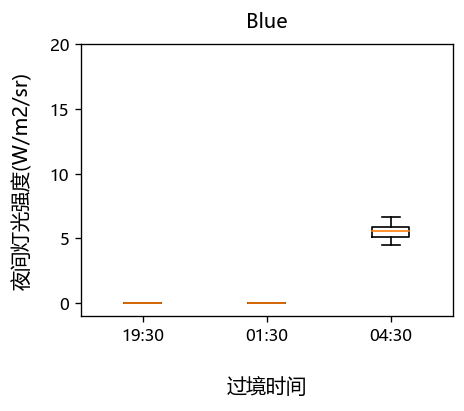

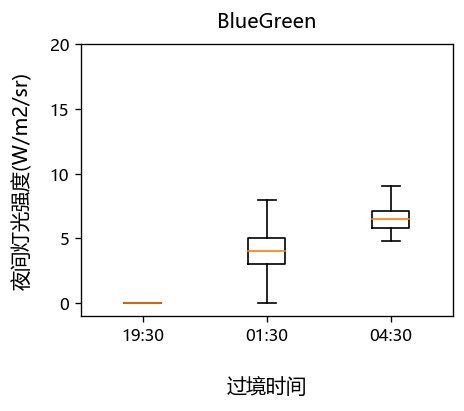

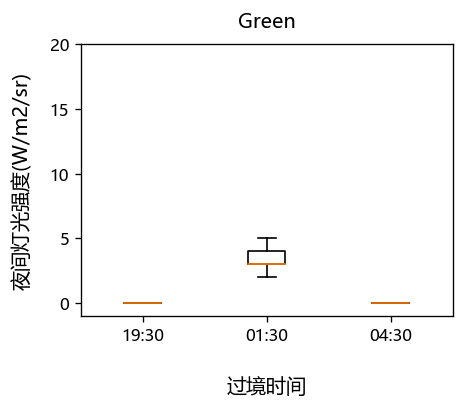

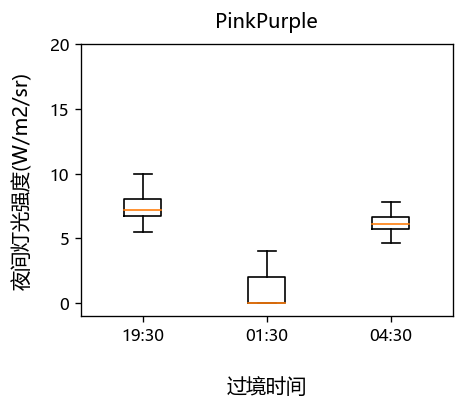

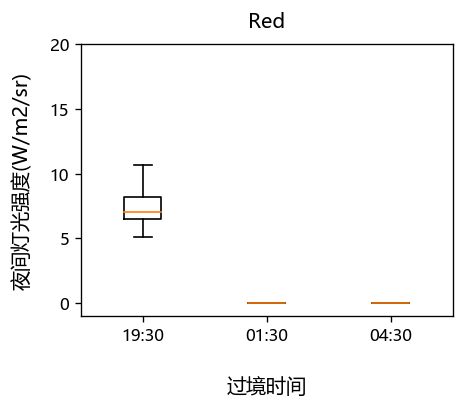

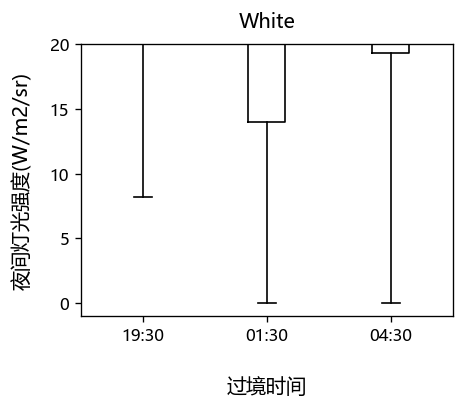

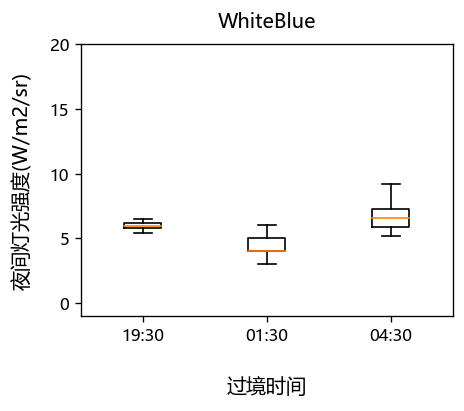

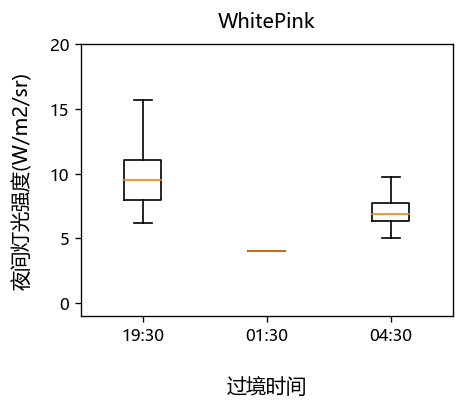

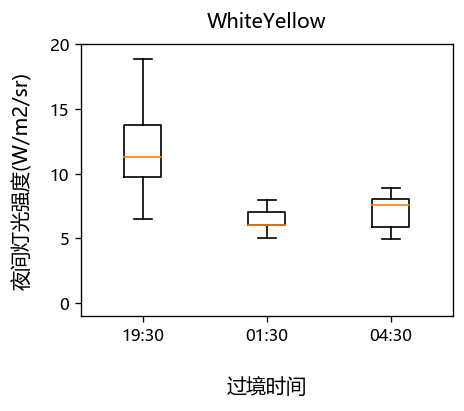

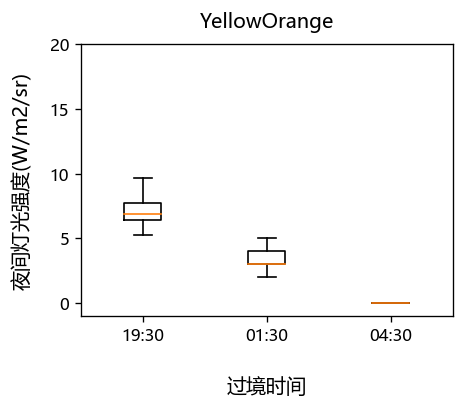

In [64]:
import openpyxl
import os
import xlsxwriter as xw
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

ms_excel_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn.xlsx'
ms_excel = pd.read_excel(ms_excel_path, sheet_name=None)
# print(ms_excel.keys())

fig_path_list = []
fig_name_list = []
num = 0
# 这里确定图表存放路径
for key in ms_excel:
    fig_prefix = 'box_'
    fig_name = fig_prefix + key + '.jpg'
    fig_name_list.append(fig_name[4:-4])
    # 统计图表存放地址
    fig_root = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\graph_cn'
    fig_path = os.path.join(fig_root, fig_name)
    fig_path_list.append(fig_path)

for value in ms_excel.values():
    data = value[['R', 'G','B']]
    box_1, box_2, box_3 = data['R'], data['G'], data['B']
    
    fig, ax = plt.subplots(figsize=(4,3), dpi=120)
    fig.subplots_adjust(wspace = 0.6)
    fig.subplots_adjust(hspace = 0.6)
#     ax = plt.subplot(4,3,i+1)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    ax.set_ylabel('夜间灯光强度(W/m2/sr)', fontsize=12, labelpad=10)
    ax.set_xlabel('过境时间', fontsize=12, labelpad=20)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    y_major_locator=MultipleLocator(5)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.set_xticklabels(['19:30','01:30','04:30'], rotation=0)
    # 箱型图绘制
    plt.boxplot([box_1, box_2, box_3], vert=True,showmeans=False, showfliers=False)
    plt.xlim(0.5,3.5)
    plt.ylim(-1,20)
    graph_title = fig_name_list[num]
    plt.title(graph_title, fontsize=12, pad=10)
    
    file_path = fig_path_list[num]
    fig.savefig(file_path, bbox_inches='tight')
    num=num+1
plt.show()

## 只看农田内的数据

dict_keys(['Blue', 'BlueGreen', 'Green', 'PinkPurple', 'Red', 'White', 'WhiteBlue', 'WhitePink', 'WhiteYellow', 'YellowOrange'])


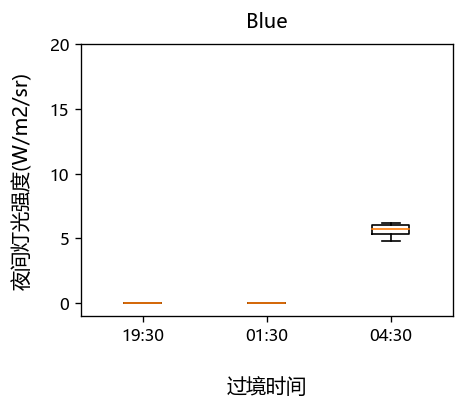

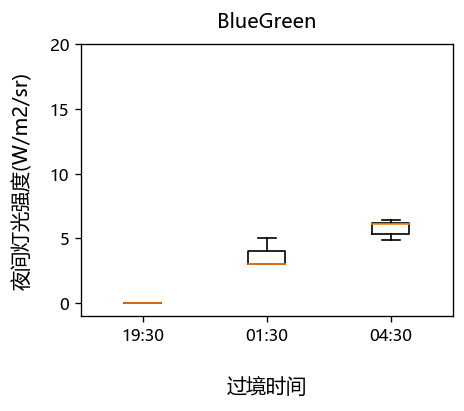

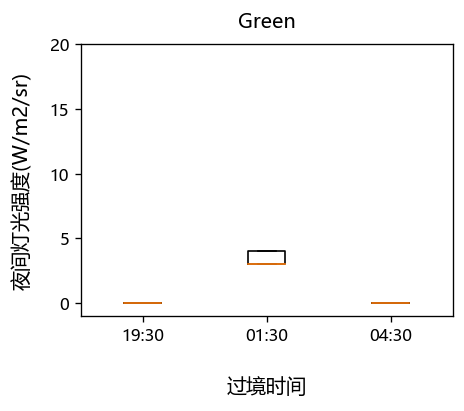

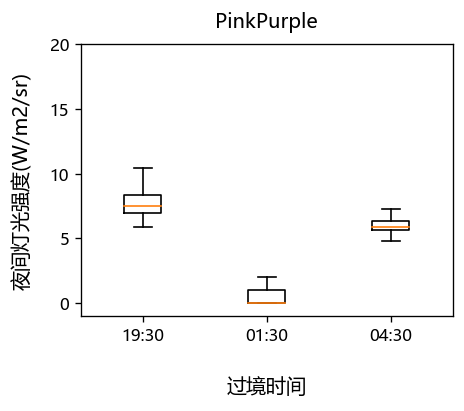

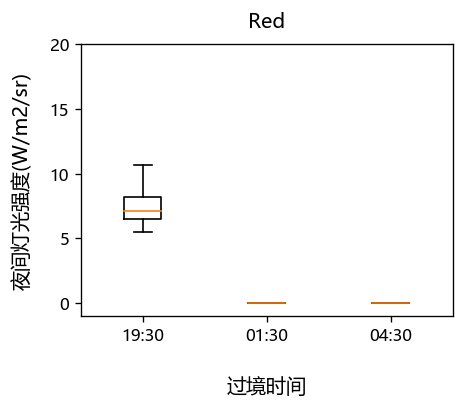

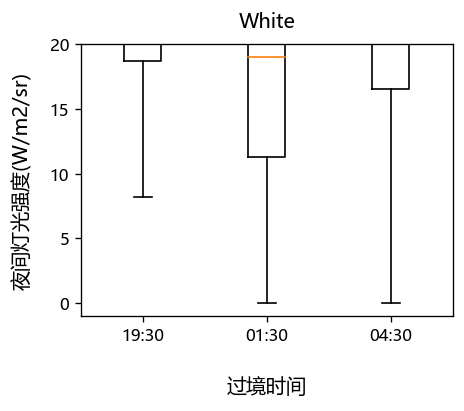

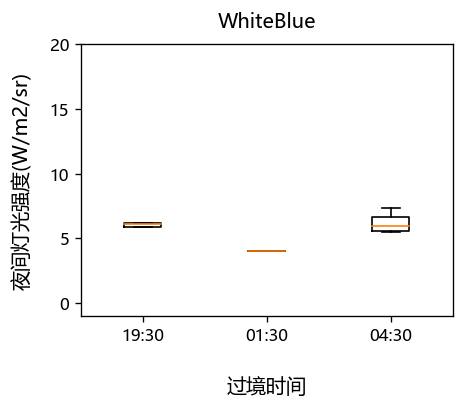

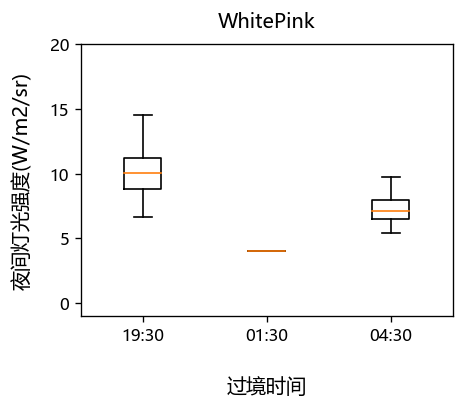

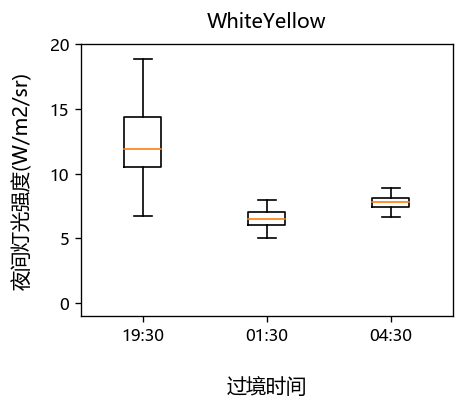

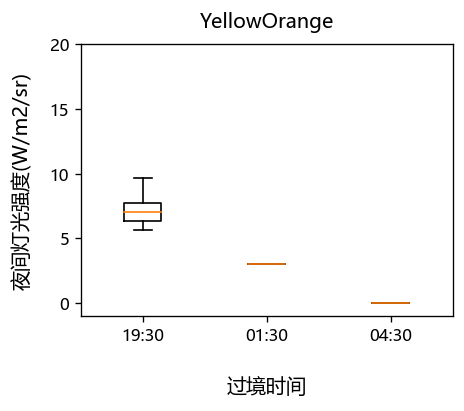

In [65]:
import openpyxl
import os
import xlsxwriter as xw
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

ms_excel_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn.xlsx'
ms_excel = pd.read_excel(ms_excel_path, sheet_name=None)
print(ms_excel.keys())

fig_path_list = []
fig_name_list = []
num = 0
# 这里确定图表存放路径
for key in ms_excel:
    fig_prefix = 'boxcrop_'
    fig_name = fig_prefix + key + '.jpg'
    fig_name_list.append(fig_name[8:-4])
    # 统计图表存放地址
    fig_root = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\graph_cn'
    fig_path = os.path.join(fig_root, fig_name)
    fig_path_list.append(fig_path)
    
for value in ms_excel.values():
    data = value[['Landcover','R','G','B']]
    index_list = []
    for index, row in data.iterrows():
        if row['Landcover'] != 5:
            index_list.append(index)
    data = data.drop(index_list)
    data = data.drop(columns='Landcover')

    box_2, box_3, box_4 = data['R'], data['G'], data['B']

    fig, ax1 = plt.subplots(figsize=(4,3), dpi=120)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False

    ax1.set_ylabel('夜间灯光强度(W/m2/sr)', fontsize=12, labelpad=10)
    ax1.set_xlabel('过境时间', fontsize=12, labelpad=20)
    ax1.tick_params(axis='x', labelsize=10)
    ax1.tick_params(axis='y', labelsize=10)
    y_major_locator=MultipleLocator(5)
    ax1.yaxis.set_major_locator(y_major_locator)
    ax1.set_xticklabels(['19:30','01:30','04:30'], rotation=0)

    # 箱型图绘制
    plt.boxplot([box_2, box_3, box_4], vert=True,showmeans=False, showfliers=False)
    
    plt.tick_params()
    plt.xlim(0.5,3.5)
    plt.ylim(-1,20)
    graph_title = fig_name_list[num]
    plt.title(graph_title, fontsize=12, pad=10)
    plt.show()
    
    file_path = fig_path_list[num]
    fig.savefig(file_path, bbox_inches='tight')
    num=num+1

## 按照作物类型的箱型图

['Blue玉米', 'Blue小麦', 'Blue玉米+小麦', 'Blue水稻', 'Blue玉米+水稻', 'Blue小麦+水稻', 'BlueGreen玉米', 'BlueGreen小麦', 'BlueGreen玉米+小麦', 'BlueGreen水稻', 'BlueGreen玉米+水稻', 'BlueGreen小麦+水稻', 'Green玉米', 'Green小麦', 'Green玉米+小麦', 'Green水稻', 'Green玉米+水稻', 'Green小麦+水稻', 'PinkPurple玉米', 'PinkPurple小麦', 'PinkPurple玉米+小麦', 'PinkPurple水稻', 'PinkPurple玉米+水稻', 'PinkPurple小麦+水稻', 'Red玉米', 'Red小麦', 'Red玉米+小麦', 'Red水稻', 'Red玉米+水稻', 'Red小麦+水稻', 'White玉米', 'White小麦', 'White玉米+小麦', 'White水稻', 'White玉米+水稻', 'White小麦+水稻', 'WhiteBlue玉米', 'WhiteBlue小麦', 'WhiteBlue玉米+小麦', 'WhiteBlue水稻', 'WhiteBlue玉米+水稻', 'WhiteBlue小麦+水稻', 'WhitePink玉米', 'WhitePink小麦', 'WhitePink玉米+小麦', 'WhitePink水稻', 'WhitePink玉米+水稻', 'WhitePink小麦+水稻', 'WhiteYellow玉米', 'WhiteYellow小麦', 'WhiteYellow玉米+小麦', 'WhiteYellow水稻', 'WhiteYellow玉米+水稻', 'WhiteYellow小麦+水稻', 'YellowOrange玉米', 'YellowOrange小麦', 'YellowOrange玉米+小麦', 'YellowOrange水稻', 'YellowOrange玉米+水稻', 'YellowOrange小麦+水稻']


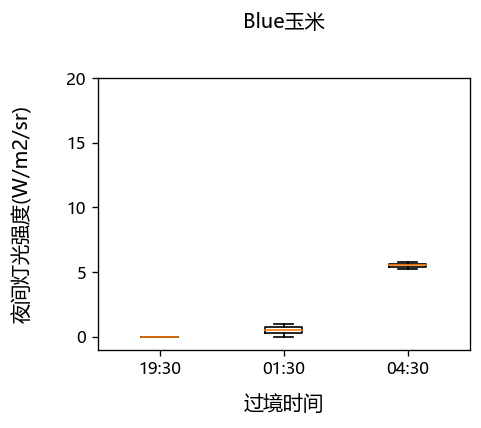

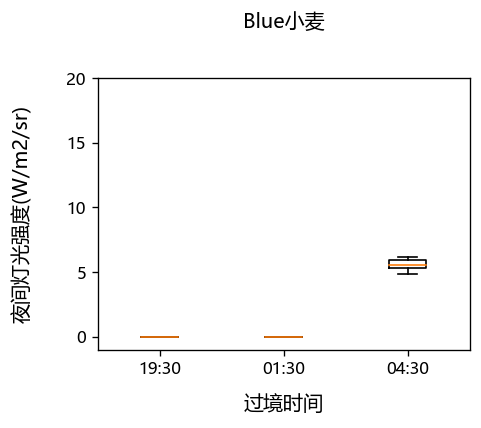

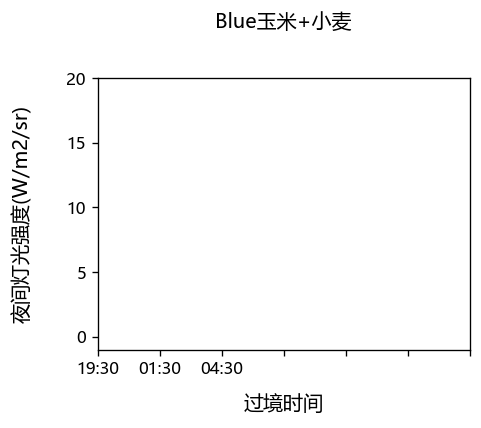

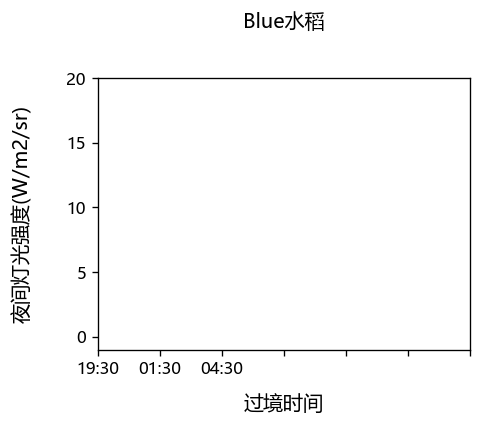

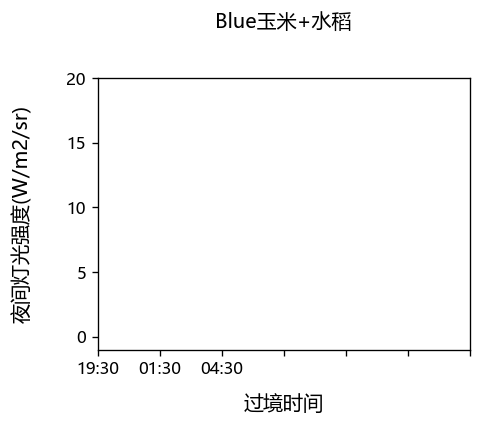

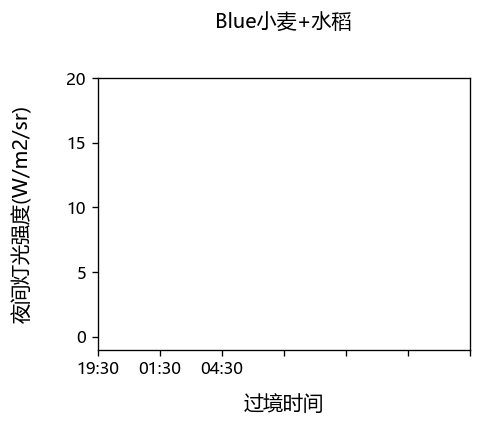

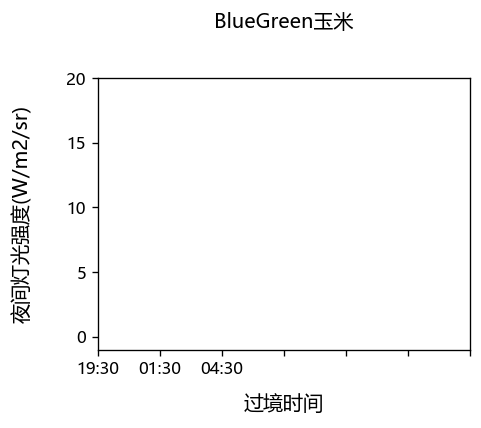

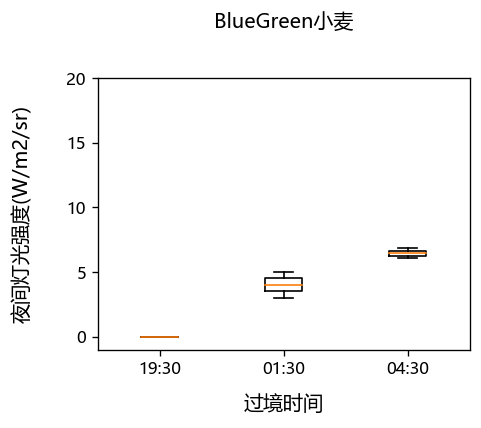

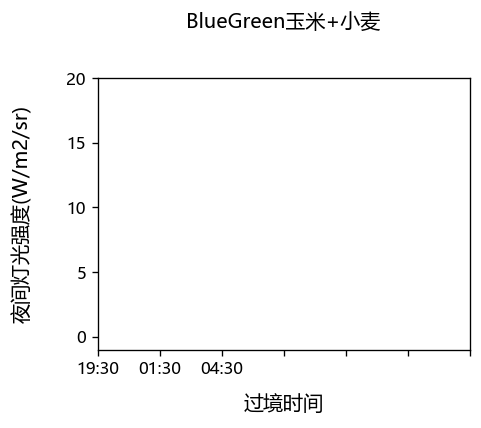

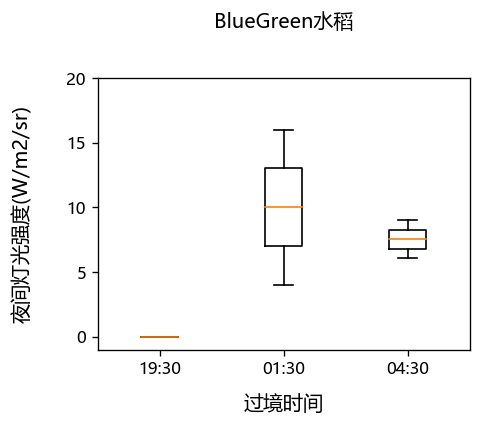

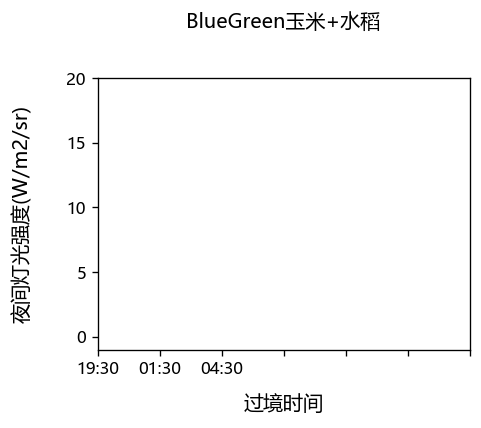

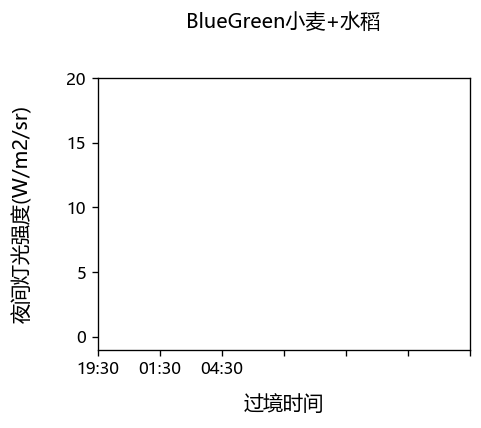

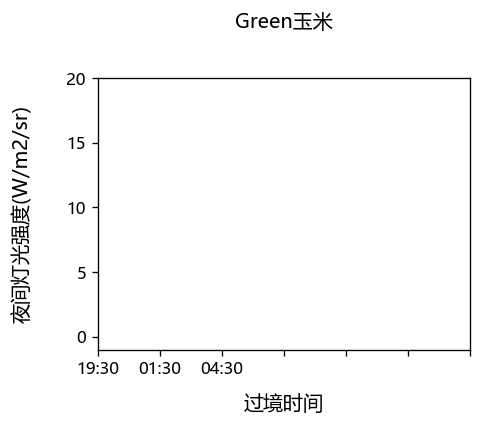

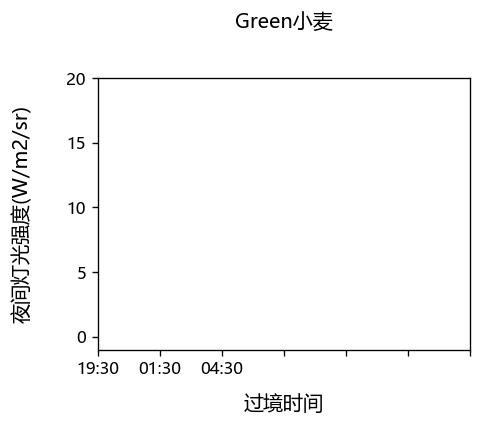

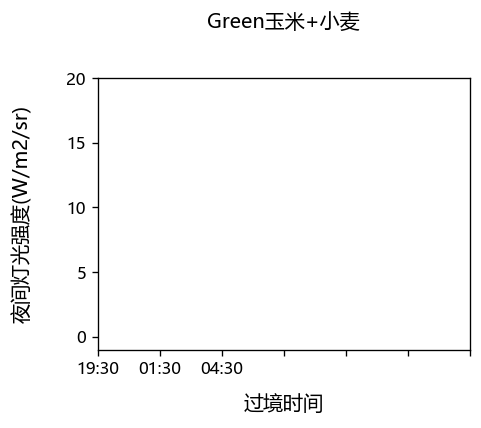

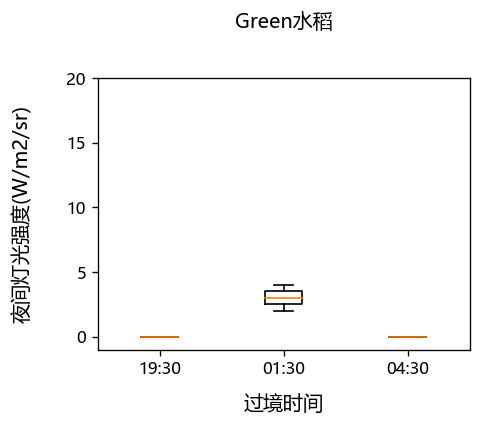

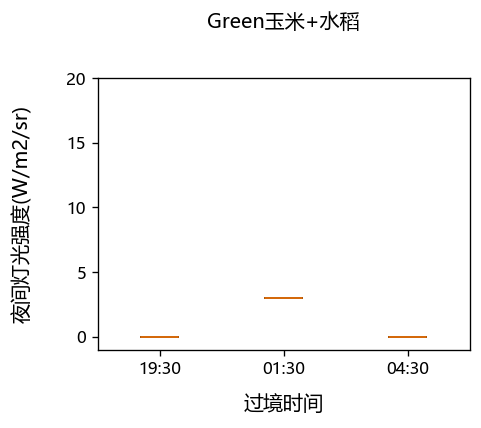

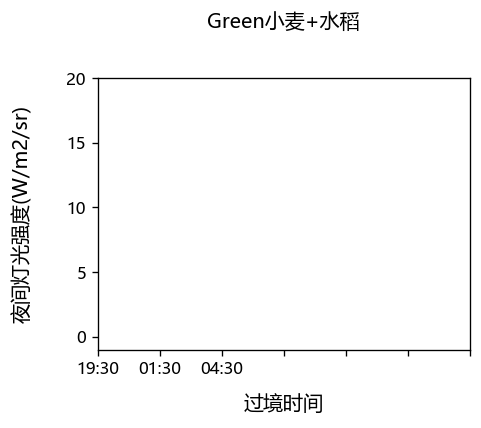

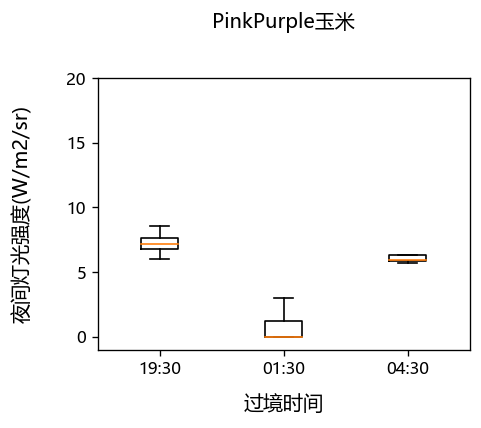

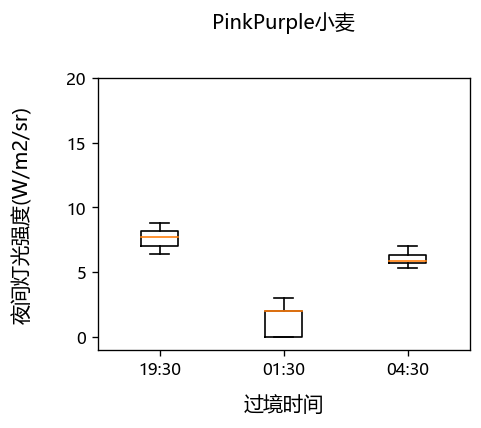

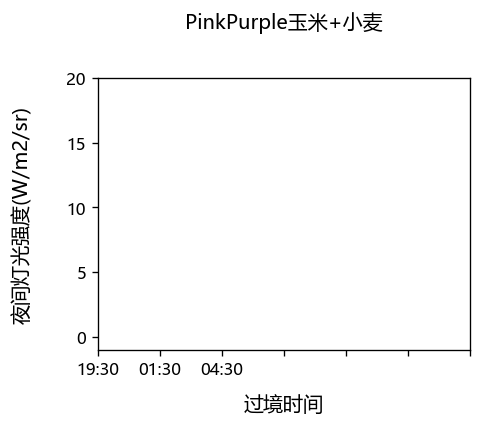

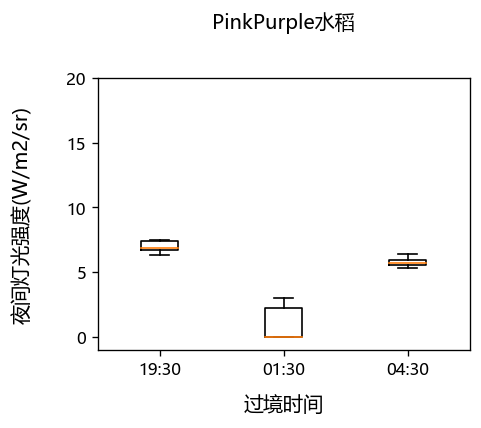

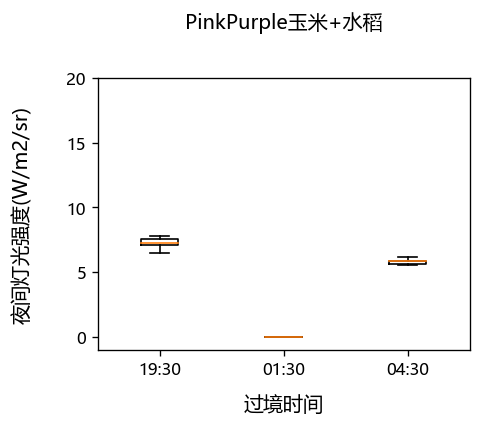

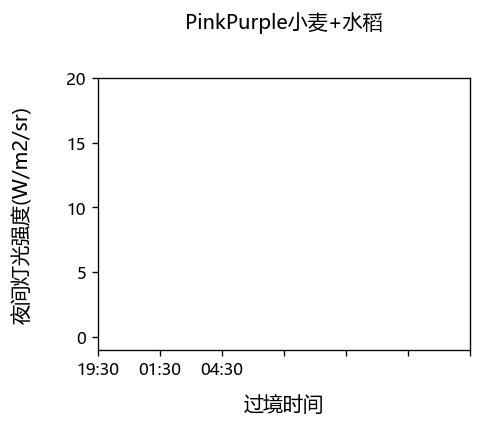

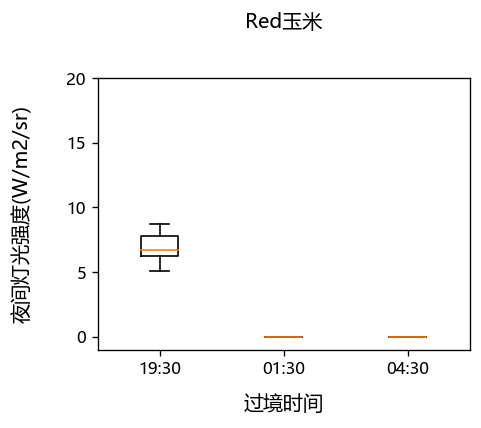

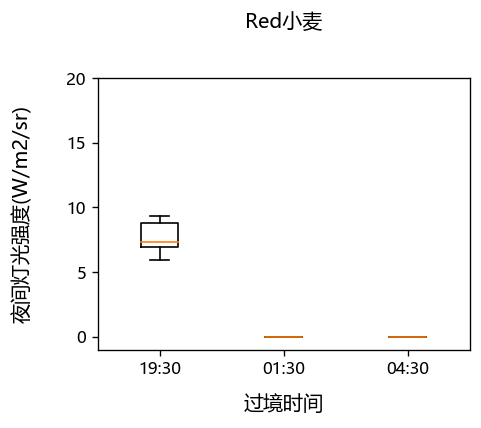

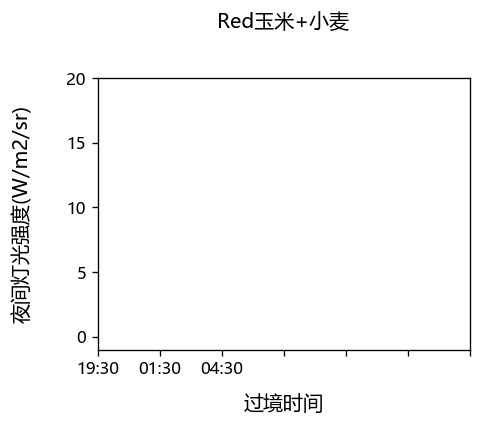

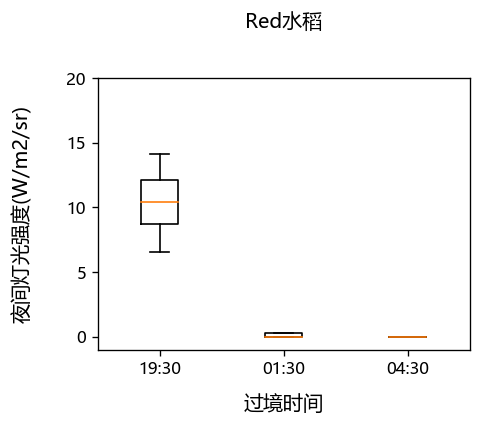

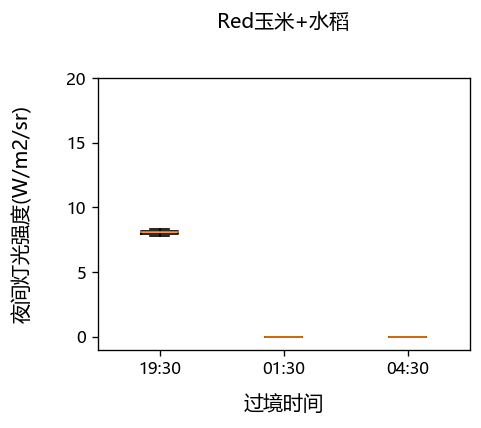

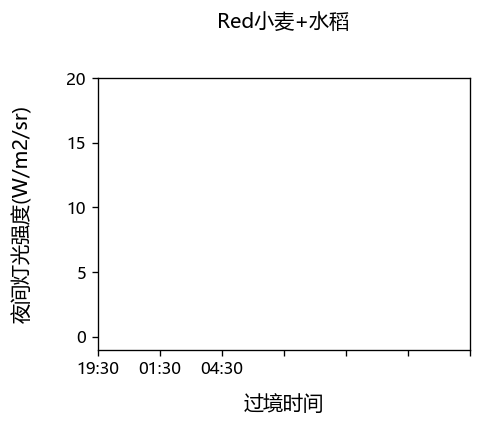

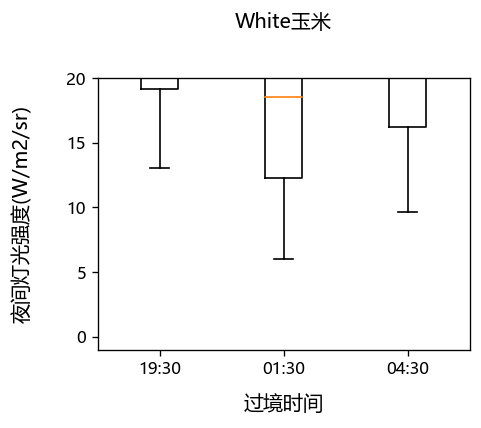

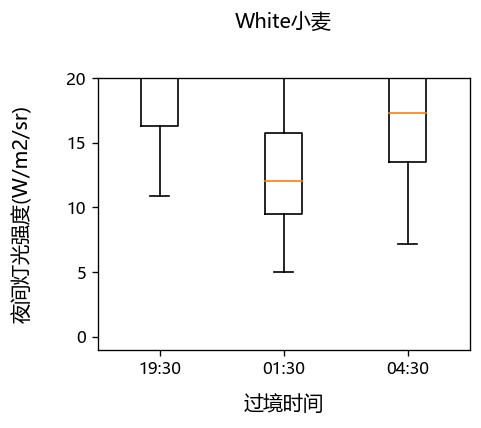

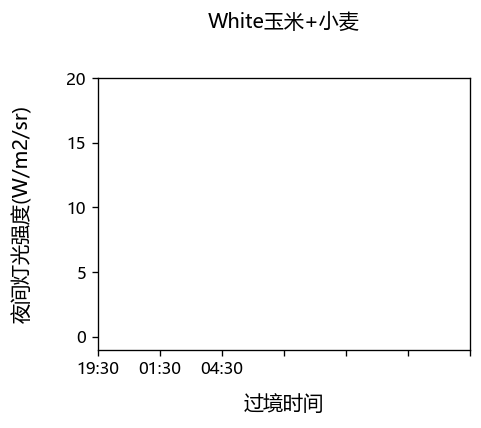

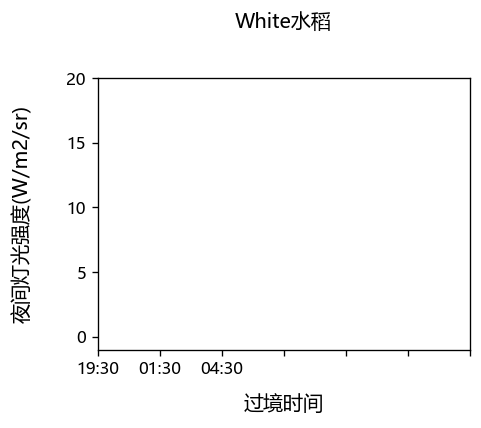

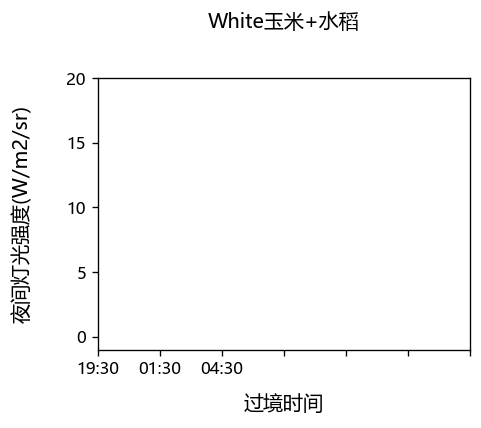

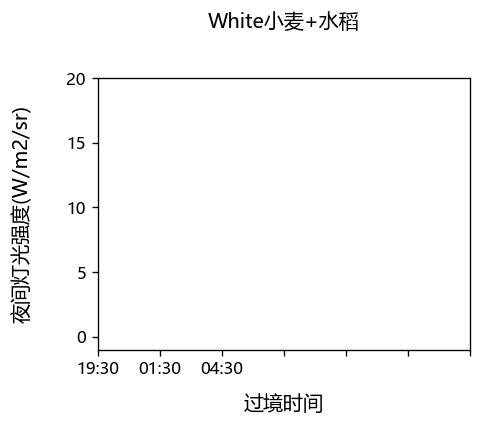

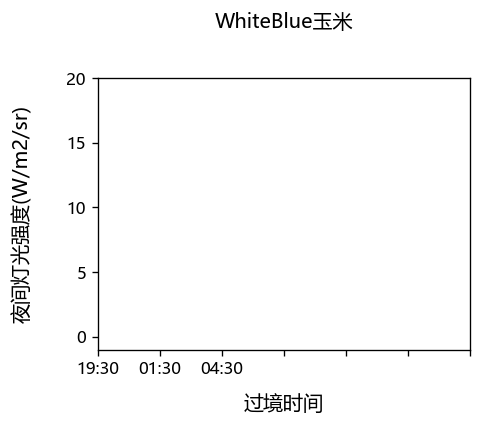

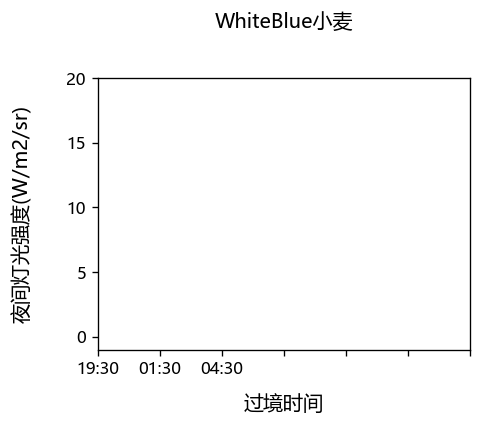

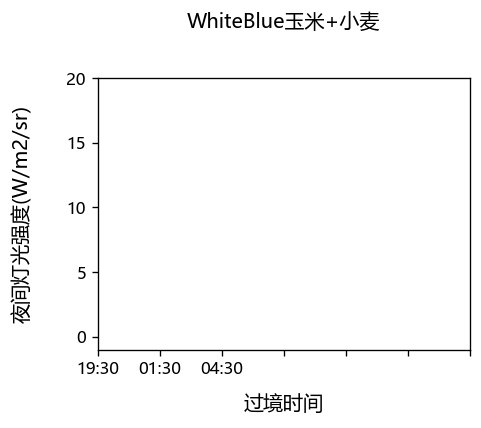

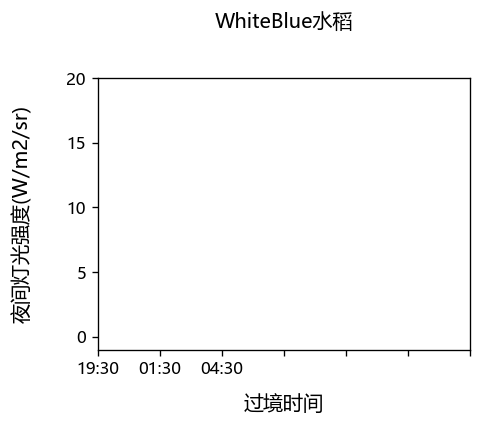

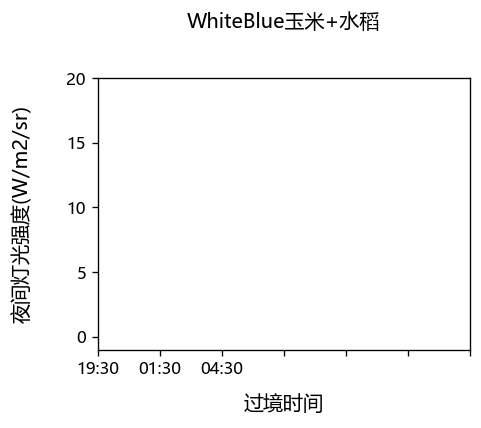

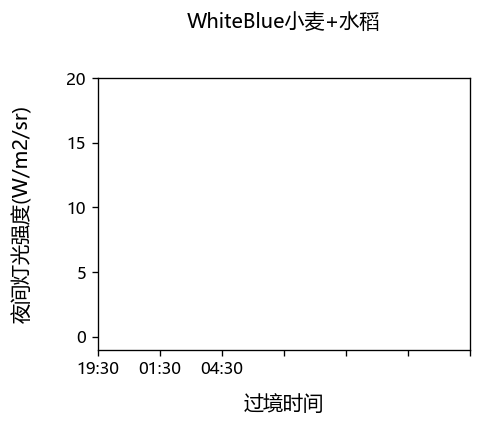

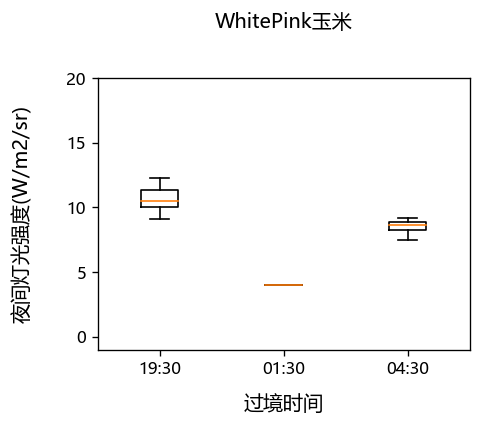

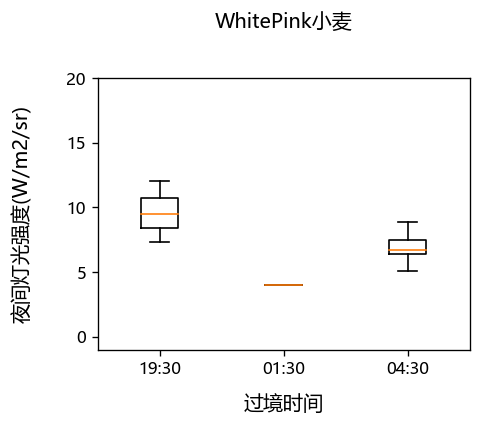

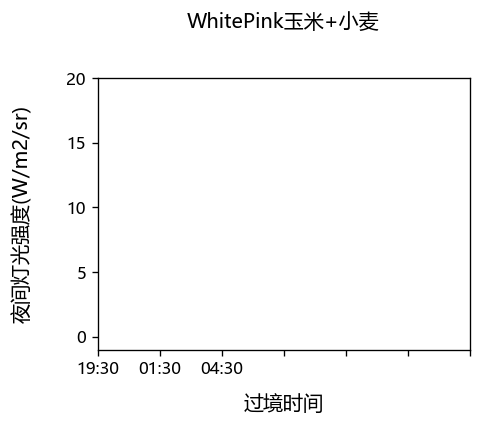

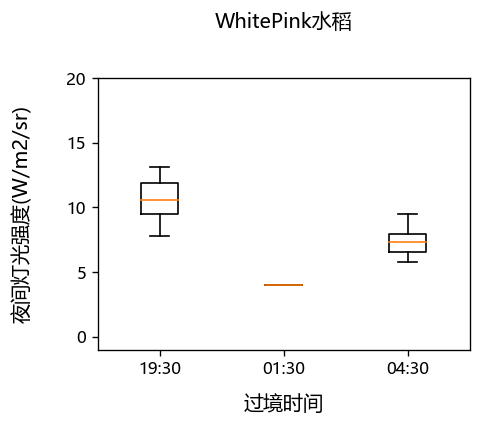

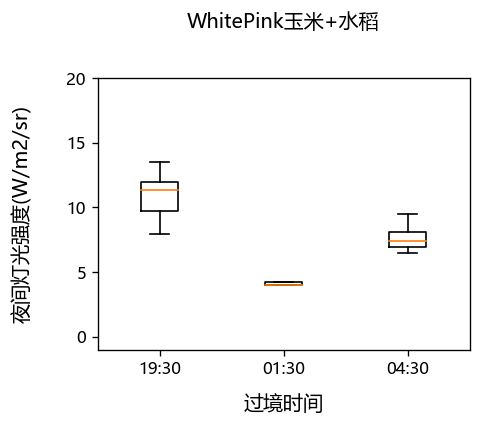

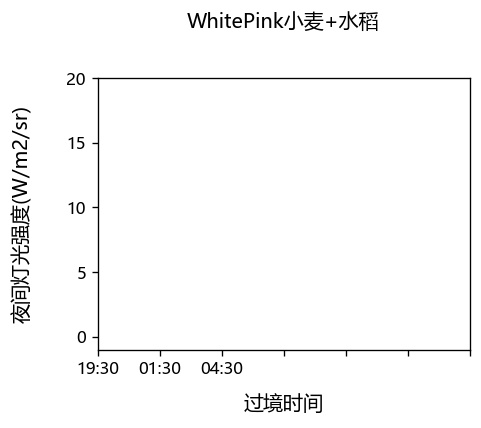

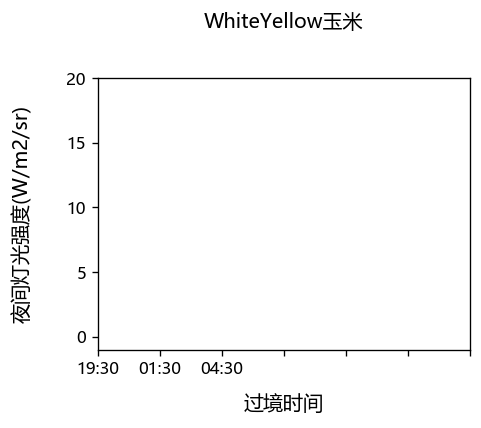

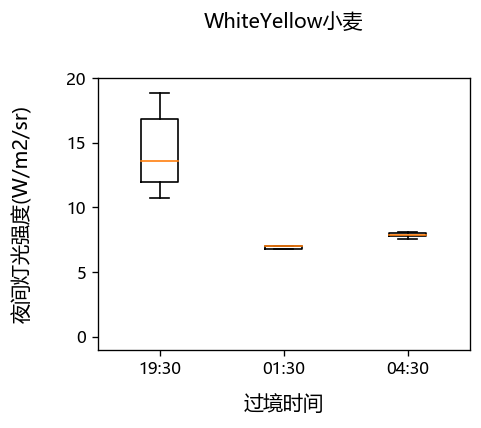

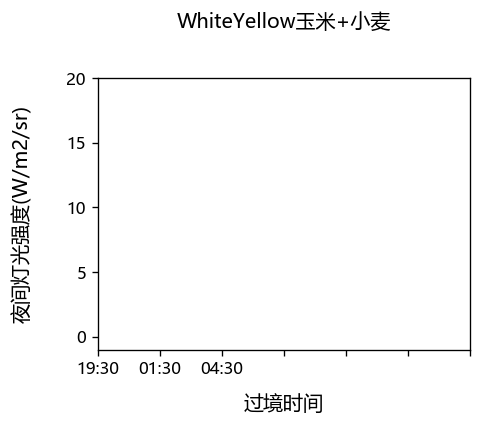

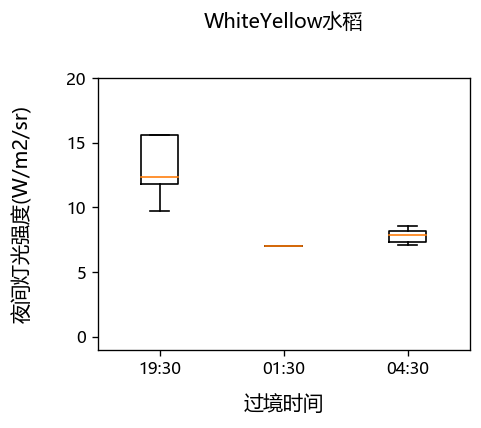

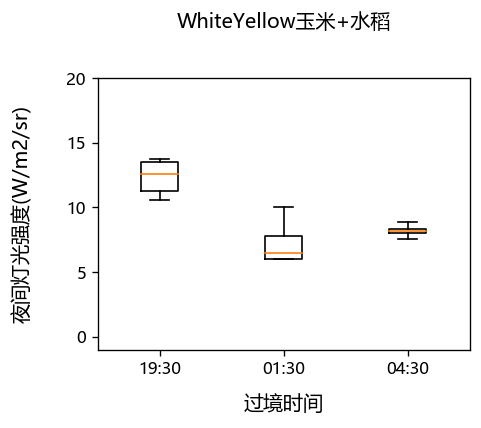

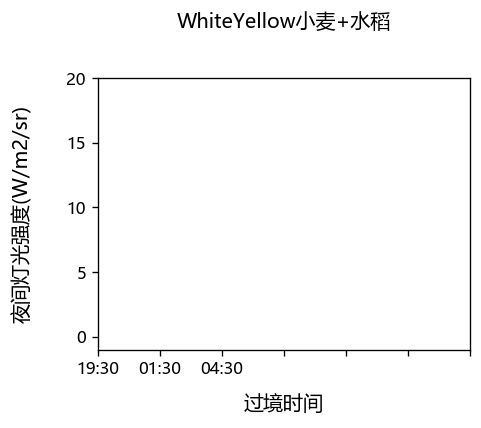

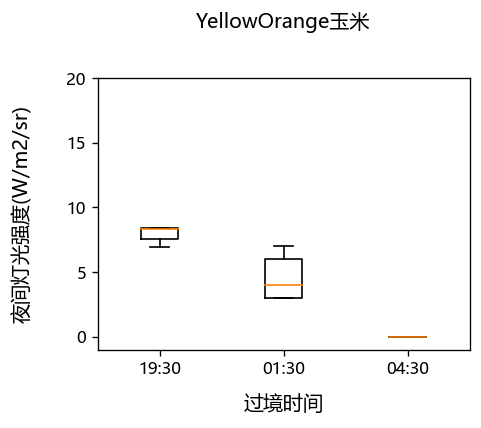

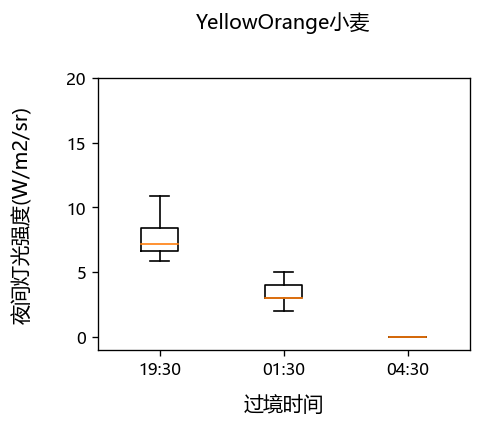

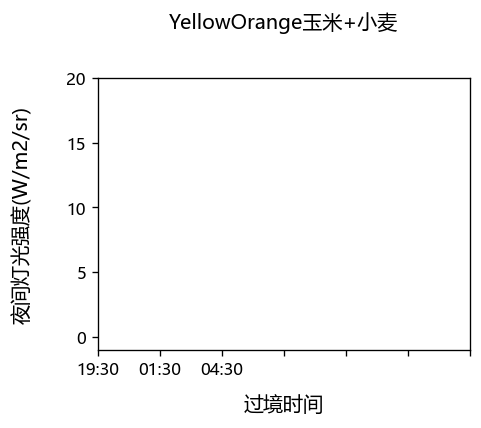

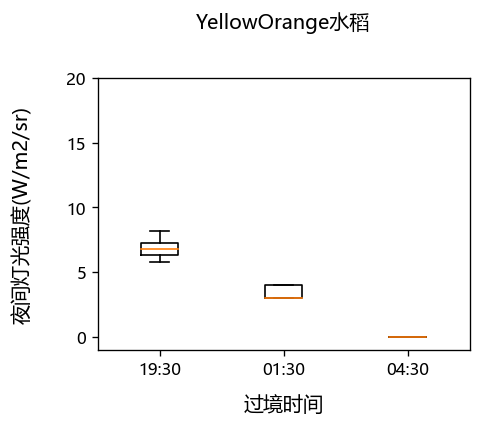

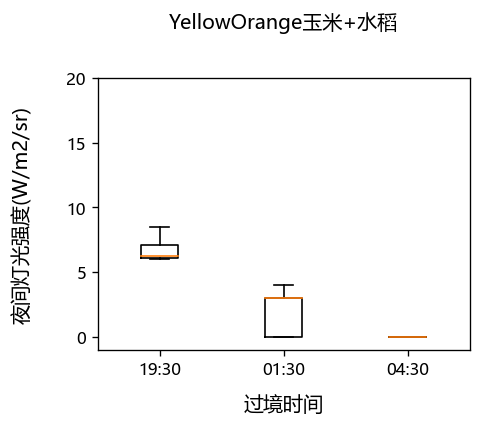

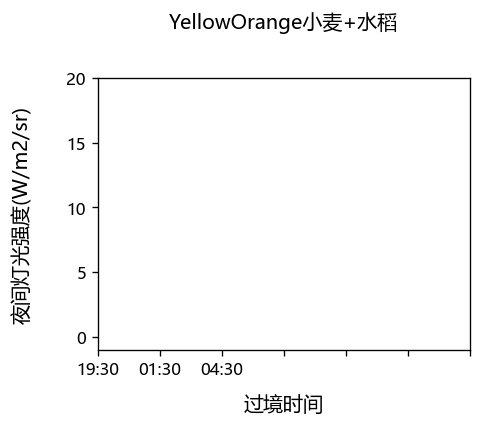

In [113]:
import openpyxl
import os
import xlsxwriter as xw
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

ms_excel_path = r'F:\Data\Extension_Research\RGB_Composite\SamplePoints\info_cn.xlsx'
ms_excel = pd.read_excel(ms_excel_path, sheet_name=None)
croptype_list = ['玉米','小麦','玉米+小麦','水稻','玉米+水稻','小麦+水稻']
fig_path_list = []
fig_name_list = []
num = 0
# 确定图表存放路径
for key in ms_excel:
    fig_prefix = 'boxcroptype_'
    for i in range(6):
        crop = croptype_list[i]
        fig_name = fig_prefix + key + crop + '.jpg'
        fig_name_list.append(fig_name[12:-4])
        # 统计图表存放地址
        fig_root = r'F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution\R2P_CropSum\land_crop_sample_cn'
        fig_path = os.path.join(fig_root, fig_name)
        fig_path_list.append(fig_path)
print(fig_name_list)    

for value in ms_excel.values():
    data = value[['crop_type', 'R', 'G','B']]
    
    # 无效数据清除
    index_list = []
    for index, row in data.iterrows():
        if row['crop_type'] == 0:
            index_list.append(index)
        if row['R'] == row['G'] == row['B'] == 0:
            index_list.append(index)
    data = data.drop(index_list)
    index_1, index_3, index_4, index_5, index_6, index_8 = [], [], [], [], [], []
    for index, row in data.iterrows():
        if row['crop_type'] != 1:
            index_1.append(index)
        if row['crop_type'] != 3:
            index_3.append(index)
        if row['crop_type'] != 4:
            index_4.append(index)
        if row['crop_type'] != 5:
            index_5.append(index)
        if row['crop_type'] != 6:
            index_6.append(index)
        if row['crop_type'] != 8:
            index_8.append(index)
    data1 = data.drop(index_1)
    data3 = data.drop(index_3)
    data4 = data.drop(index_4)
    data5 = data.drop(index_5)
    data6 = data.drop(index_6)
    data8 = data.drop(index_8)
    
    # 绘图数据准备
    data_list = [data1,data3,data4,data5,data6,data8]
    box_list = [[data1['R'], data1['G'], data1['B']],[data3['R'], data3['G'], data3['B']],[data4['R'], data4['G'], data4['B']],
           [data5['R'], data5['G'], data5['B']],[data6['R'], data6['G'], data6['B']],[data8['R'], data8['G'], data8['B']]]
    croptype_list = ['玉米','小麦','玉米+小麦','水稻','玉米+水稻','小麦+水稻']

    # 箱型图绘制
    for i in range(6):
        # 绘图窗口准备
        fig, ax1 = plt.subplots(figsize=(4,3), dpi=120)
        fig.subplots_adjust(wspace = 0.6)
        fig.subplots_adjust(hspace = 0.6)
        # 整体属性设置
        graph_title = fig_name_list[num]
        plt.title(graph_title, fontsize=12, pad=30)
        plt.rcParams['font.sans-serif']=['Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False
        plt.xlabel('过境时间', fontsize=12, labelpad=10)
        plt.ylabel('夜间灯光强度(W/m2/sr)', fontsize=12, labelpad=20)
        plt.ylim(-1,20)
        plt.tick_params(axis='x', labelsize=10)
        plt.tick_params(axis='y', labelsize=10)
        # 子图属性设置
        major_locator=MultipleLocator(5)
        ax1.yaxis.set_major_locator(major_locator)
        ax1.set_xticklabels(['19:30','01:30','04:30'], rotation=0)
        plt.xlim(0.5,3.5)
        if data_list[i].shape[0] > 1:
            ax = plt.boxplot(box_list[i], vert=True,showmeans=False, showfliers=False)
            # 保存到本地
            file_path = fig_path_list[num]
            fig.savefig(file_path, bbox_inches='tight')
            num = num + 1
        else:
            # 保存到本地
            file_path = fig_path_list[num]
            fig.savefig(file_path, bbox_inches='tight')
            num = num + 1
        plt.show()

# 基于农作物分布数据的统计图表

> 数据引用：
> 骆玉川；张朝. 2000-2019年全国三大粮食作物1km种植分布数据集[DB/OL]. 国家生态科学数据中心, 2022. doi:10.12199/nesdc.ecodb.rs.2022.016. cstr:15732.11.nesdc.ecodb.rs.2022.016
        
> 文献引用：
> Yuchuan Luo, Zhao Zhang, Ziyue Li, et al. Identifying the spatiotemporal changes of annual harvesting areas for three staple crops in China by integrating multi-data sources. Environ. Res. Lett. 15, 074003 (2020). https://doi.org/10.1088/1748-9326/ab80f0

## 农作物相关的区域统计

In [7]:
import os
import arcpy
from arcpy import env
from arcpy.sa import *

workspace = r"F:\Data\Extension_Research\RGB_Composite\Landcover\MCD12Q1\cn_reclass"
shp_path = r"F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution\R2P_CropSum\shp"
output_path = r"F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution\R2P_CropSum\info_R2Pcrop"

shp_name_pre = os.listdir(shp_path)
shp_name = []
for name in shp_name_pre:
    if name[-4:] == '.shp':
        shp_name.append(name)

zoneField = "FID"
datanames = os.listdir(workspace)

shp = os.path.join(shp_path, shp_name[0])

for dataname in datanames:
    if os.path.splitext(dataname)[1] == '.tif':
        data_name = os.path.splitext(dataname)[0]
        arcpy.CheckOutExtension("Spatial")
        file_name = data_name.split('.')[0]
        raster = workspace + "/" + dataname
        outTable = (output_path + "/" + file_name + ".dbf")
        print(raster)
        print(outTable)
        outZSaT = ZonalStatisticsAsTable(shp, zoneField, raster, outTable, "DATA", "ALL")

print('finish')

F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution/crop_sum.tif
F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution\R2G_CropSum\info_R2Gcrop/crop_sum.dbf


## 直接读取dbf文件为DataFrame

### 农作物分布栅格转点

['crop_sum.dbf', 'DVNL_2013.dbf', 'F152013_intercal.dbf', 'F182013.dbf', 'MCD12Q1_cn_reclass.dbf']
            ID  crop_type          R    G         B  Landcover
23          23          1   6.232924  0.0  6.088617          5
24          24          1   6.519982  0.0  0.000000          5
26          26          1   0.000000  0.0  5.574873          5
28          28          1   5.942087  0.0  0.000000          5
29          29          1   0.000000  0.0  5.817574          5
...        ...        ...        ...  ...       ...        ...
759153  766993          3   8.907296  5.0  7.578002          5
759157  766997          3  10.169272  4.0  7.006812          5
759224  767064          3   8.367746  4.0  6.560123          5
759226  767066          3   6.798541  3.0  5.017623          5
759295  767135          3   8.716083  4.0  6.108608          5

[302152 rows x 6 columns]


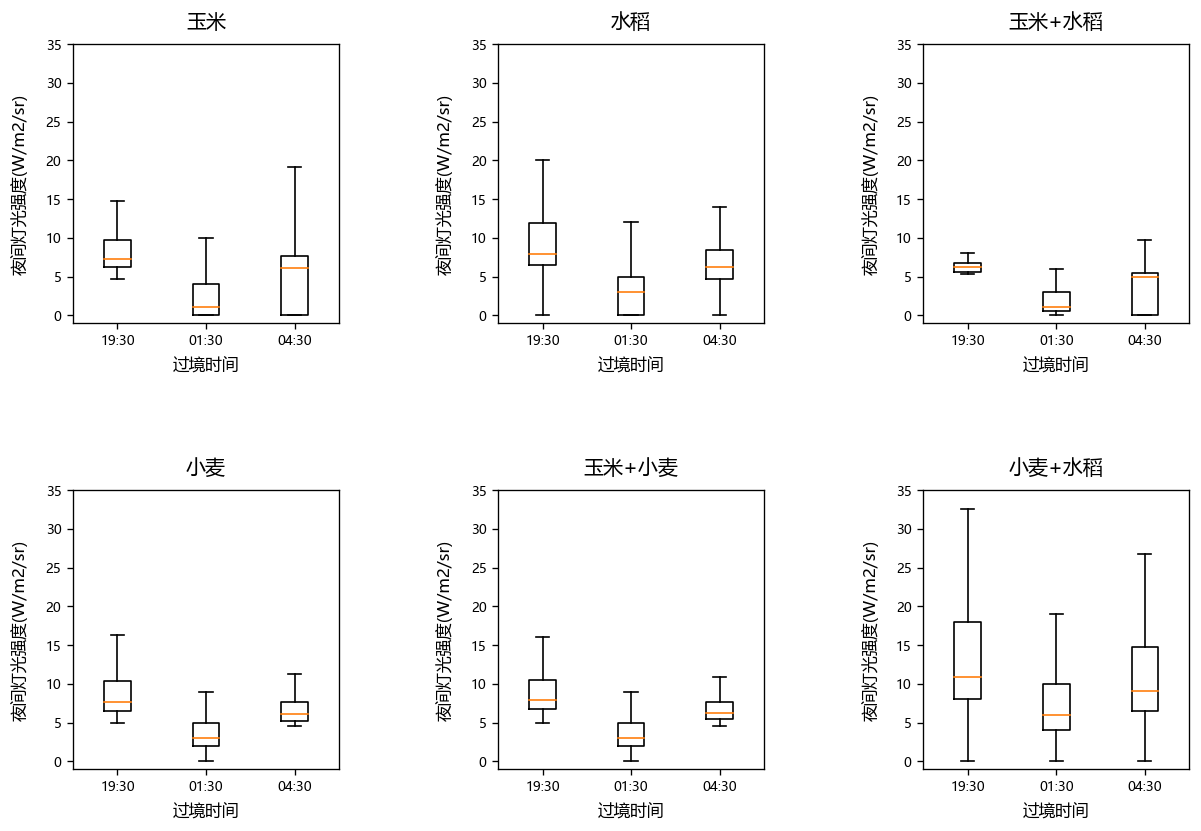

In [1]:
# 栅格转点数据
import os
import pandas as pd
from dbfread import DBF
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

dbf_path = r'F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution\R2P_CropSum\info_R2Pcrop'
file_name = os.listdir(dbf_path)
dbf_name = []
for name in file_name:
    if name[-4:] == '.dbf':
        dbf_name.append(name)
print(dbf_name)
df = pd.DataFrame({'FID_':list(range(0,1000000))})
for name in dbf_name:
    dbf = os.path.join(dbf_path, name)
    data_dbf = DBF(dbf, encoding='GBK')
    data = pd.DataFrame(iter(data_dbf))
    data = data[['FID_','MIN']]
    df = pd.merge(df, data, on='FID_')
df.columns = ['ID', 'crop_type', 'G', 'B', 'R','Landcover']
df = df[['ID', 'crop_type', 'R', 'G', 'B','Landcover']]

# 无效数据清除
index_list = []
for index, row in df.iterrows():
    if row['R'] == row['G'] == row['B'] == 0:
        index_list.append(index)
    elif row['Landcover'] !=5:
        index_list.append(index)
df = df.drop(index_list)
print(df)

index_1, index_3, index_4, index_5, index_6, index_8 = [], [], [], [], [], []
for index, row in df.iterrows():
    if row['crop_type'] != 1:
        index_1.append(index)
    if row['crop_type'] != 3:
        index_3.append(index)
    if row['crop_type'] != 4:
        index_4.append(index)
    if row['crop_type'] != 5:
        index_5.append(index)
    if row['crop_type'] != 6:
        index_6.append(index)
    if row['crop_type'] != 8:
        index_8.append(index)
data1 = df.drop(index_1)
data3 = df.drop(index_3)
data4 = df.drop(index_4)
data5 = df.drop(index_5)
data6 = df.drop(index_6)
data8 = df.drop(index_8)

# 绘图数据准备
box_list = [[data1['R'], data1['G'], data1['B']],[data3['R'], data3['G'], data3['B']],[data4['R'], data4['G'], data4['B']],
           [data5['R'], data5['G'], data5['B']],[data6['R'], data6['G'], data6['B']],[data8['R'], data8['G'], data8['B']]]
croptype_list = ['玉米','水稻','玉米+水稻','小麦','玉米+小麦','小麦+水稻']

# 绘图窗口准备
fig, ax1 = plt.subplots(figsize=(12,8), dpi=120)
fig.subplots_adjust(wspace = 0.6)
fig.subplots_adjust(hspace = 0.6)

# 箱型图绘制
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    # 整体属性设置
    plt.title(croptype_list[i], fontsize=12, pad=10)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.xlabel('过境时间', fontsize=10, labelpad=5)
    plt.ylabel('夜间灯光强度(W/m2/sr)', fontsize=10, labelpad=10)
    plt.ylim(-1,35)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels([])
    ax.set_xticklabels(['19:30','01:30','04:30'], rotation=0)
    plt.boxplot(box_list[i], vert=True,showmeans=False, showfliers=False)

plt.show()

#     # 保存到本地
#     file_path = fig_path_list[num]
#     fig.savefig(file_path, bbox_inches='tight')

### 农作物分布栅格转面

['crop_sum.dbf', 'DVNL_2013.dbf', 'F152013_intercal.dbf', 'F182013.dbf', 'MCD12Q1_cn_reclass.dbf']
            ID  crop_type          R     G          B  Landcover
148        155          1  15.915277   5.0  11.151719          5
153        160          1  16.854803   4.0   8.422833          5
154        161          5  13.453519   0.0   8.723607          5
155        162          1  12.486562   0.0   8.662451          5
158        165          3  13.176682  10.0   8.780375          5
...        ...        ...        ...   ...        ...        ...
200568  222940          3   6.102386   1.0   4.976024          5
200605  222987          3   5.772109   3.0   5.225660          5
200650  223039          3   8.230644   3.0   5.447874          5
200746  223150          3   6.062386   3.0   4.799683          5
200823  223241          3  27.919413  11.0  11.036581          5

[38881 rows x 6 columns]


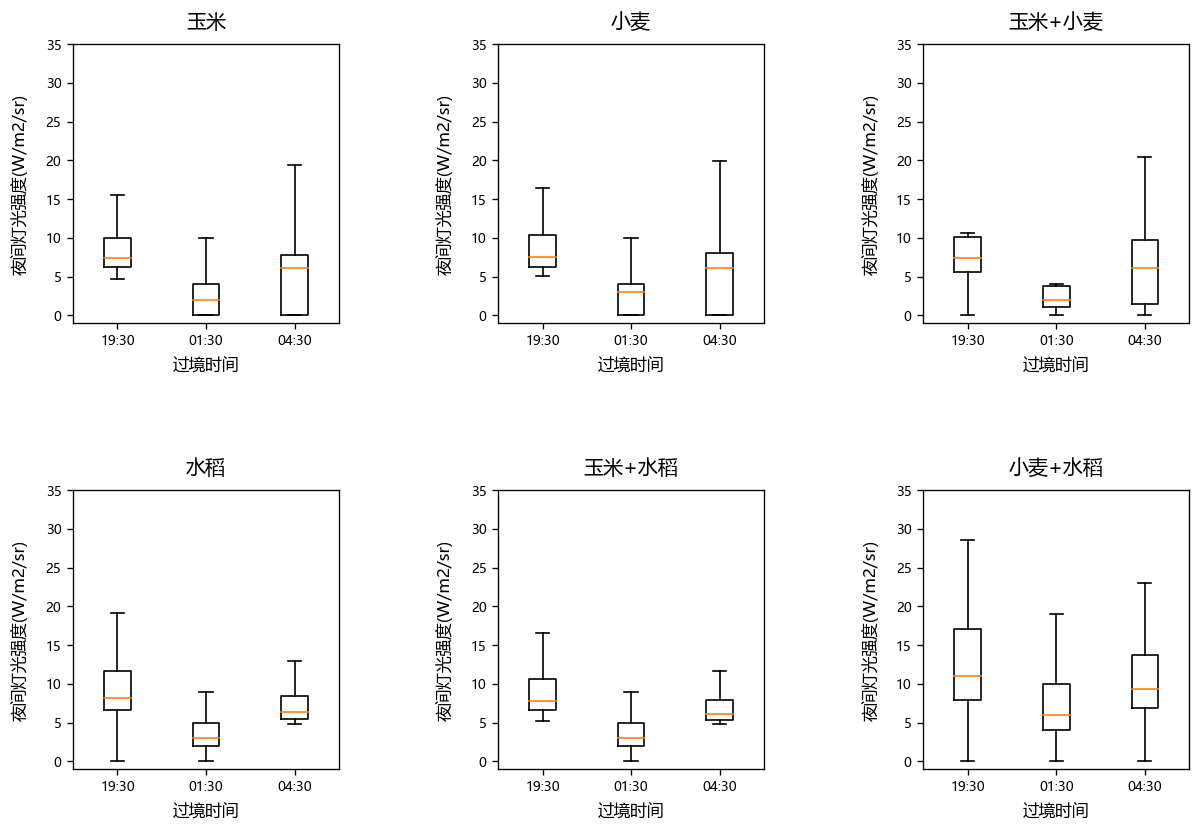

In [1]:
# 栅格转面数据
import os
import pandas as pd
from dbfread import DBF
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

dbf_path = r'F:\Data\Extension_Research\RGB_Composite\PrimaryIndustry\distrbution\R2G_CropSum\info_R2Gcrop'
file_name = os.listdir(dbf_path)
dbf_name = []
for name in file_name:
    if name[-4:] == '.dbf':
        dbf_name.append(name)
print(dbf_name)
df = pd.DataFrame({'FID_':list(range(0,1000000))})
for name in dbf_name:
    dbf = os.path.join(dbf_path, name)
    data_dbf = DBF(dbf, encoding='GBK')
    data = pd.DataFrame(iter(data_dbf))
    data = data[['FID_','MIN']]
    df = pd.merge(df, data, on='FID_')
df.columns = ['ID', 'crop_type', 'G', 'B', 'R','Landcover']
df = df[['ID', 'crop_type', 'R', 'G', 'B','Landcover']]

# 无效数据清除
index_list = []
for index, row in df.iterrows():
    if row['R'] == row['G'] == row['B'] == 0:
        index_list.append(index)
    elif row['Landcover'] !=5:
        index_list.append(index)
df = df.drop(index_list)
print(df)

index_1, index_3, index_4, index_5, index_6, index_8 = [], [], [], [], [], []
for index, row in df.iterrows():
    if row['crop_type'] != 1:
        index_1.append(index)
    if row['crop_type'] != 3:
        index_3.append(index)
    if row['crop_type'] != 4:
        index_4.append(index)
    if row['crop_type'] != 5:
        index_5.append(index)
    if row['crop_type'] != 6:
        index_6.append(index)
    if row['crop_type'] != 8:
        index_8.append(index)
data1 = df.drop(index_1)
data3 = df.drop(index_3)
data4 = df.drop(index_4)
data5 = df.drop(index_5)
data6 = df.drop(index_6)
data8 = df.drop(index_8)

# 绘图数据准备
box_list = [[data1['R'], data1['G'], data1['B']],[data3['R'], data3['G'], data3['B']],[data4['R'], data4['G'], data4['B']],
           [data5['R'], data5['G'], data5['B']],[data6['R'], data6['G'], data6['B']],[data8['R'], data8['G'], data8['B']]]
croptype_list = ['玉米','小麦','玉米+小麦','水稻','玉米+水稻','小麦+水稻']

# 绘图窗口准备
fig, ax1 = plt.subplots(figsize=(12,8), dpi=120)
fig.subplots_adjust(wspace = 0.6)
fig.subplots_adjust(hspace = 0.6)

# 箱型图绘制
for i in range(6):
    ax = plt.subplot(2,3,i+1)
    # 整体属性设置
    plt.title(croptype_list[i], fontsize=12, pad=10)
    plt.rcParams['font.sans-serif']=['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.xlabel('过境时间', fontsize=10, labelpad=5)
    plt.ylabel('夜间灯光强度(W/m2/sr)', fontsize=10, labelpad=10)
    plt.ylim(-1,35)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    ax.set_xticklabels(['19:30','01:30','04:30'], rotation=0)
    plt.boxplot(box_list[i], vert=True,showmeans=False, showfliers=False)

plt.show()

#     # 保存到本地
#     file_path = fig_path_list[num]
#     fig.savefig(file_path, bbox_inches='tight')

# 附录

## IGBP标准下的土地利用类型
**英文版**  
'water', 'Evergreen Needleleaf foreat', 'Evergreen Broadleaf forest', 'Deciduous Needleleaf forest',  
'Deciduous Broadleaf forest', 'Mixed forest', 'Closed shrublands', 'Open shrublands',  
'Woody savannas', 'Savannas', 'Grasslands', 'Permanent', 'Croplands', 'Urban and Built-up',  
'Cropland/Natural vegetation mosaic', 'Snow and ice', 'Barren or sparsely vegetated', 'Unclassified'  
  
**中文版**  
'水体', '常绿针叶林', '常绿阔叶林', '落叶针叶林',  
'落叶阔叶林', '混交林', '密集灌木', '疏松灌木',  
'多树荒原', '荒原', '草地', '永久湿地', '农田', '城市与建成区',  
'农田与植被交界', '冰雪', '贫瘠土地', '未分类'